In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm.notebook import tqdm
import random
#Imports and setup for ML.
import os,sys,pickle
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.utils import plot_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from matplotlib import cm
from matplotlib.colors import ListedColormap
gpus = tf.config.list_physical_devices('GPU')
#!pip install pqdm
from pqdm.processes import pqdm
from keras import backend as K

def recall_m(y_true, y_pred): # TPR
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # P
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN

#Model definition
def save_model_history(model,history_filename):
    with open(history_filename,'wb') as f:
        pickle.dump(model.history.history, f)
        
model_checkpoint_callback = ModelCheckpoint(filepath='./ckpts/test_ckpt.keras',
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)

print('finished setup')
######################################################################
def myCNN(args):
    dx,dy,nChannels = args
    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(7,7),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    x = Dropout(0.25,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(7,7),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    x = Dropout(0.2,name='Drop_C2')(x)
    # Batch Norm
    x = BatchNormalization(name='BatchNorm')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(7,7),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    x = Dropout(0.2,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(7,7),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    #add max pooling here, size 2,2
    x = MaxPooling2D(pool_size=(2,2),name='MP_C4')(x)
    x = Dropout(0.2,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(512,activation='relu',name='Dense_1')(x)
    x = Dropout(0.25,name='DropFCL_1')(x)
    x = Dense(128,activation='relu',name='Dense_2')(x)
    x = Dropout(0.25,name='DropFCL_2')(x)
    x = Dense(1,activation='sigmoid',name='Dense_3')(x)

    # connect and compile
    model = Model(inputs=inputs,outputs=x)
    model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
    return model

print('defined model')

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,use_cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig,ax = plt.subplots(figsize=(5, 5))
    plt.imshow(cm.T, interpolation='nearest', cmap=cmap)

    if use_cbar==True:
        cb = plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=20)
        plt.yticks(tick_marks, target_names,fontsize=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[j, i]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=20)
        else:
            plt.text(j, i, "{:,}".format(cm[j, i]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=20)


    plt.tight_layout()
    plt.ylabel('Predicted Label',fontsize=25)
    plt.xlabel('True Label'.format(accuracy, misclass),fontsize=25)

    plt.show()
#plotting etc
import matplotlib as mpl
mpl.rcParams['text.usetex']=True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'sans-serif',
        'mathtext.fontset': 'dejavusans',
    }
)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.pad'] = 9
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
plt.rcParams['axes.titlesize'] = 50
mpl.rcParams['figure.dpi'] = 500

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

def binned_mean_ada(x,y,bins):
    xspace = histedges_equalN(x,bins)
    ymeds = []
    yerrs = []
    xspace_plot = []
    xerrs = []
    for i in range(len(xspace)-1):
        xmin = xspace[i]
        xmax = xspace[i+1]
        ys = y[(x>=xmin)&(x<xmax)]
        loc_med = np.mean(ys)
        loc_err = np.std(ys)
        ymeds.append(loc_med)
        yerrs.append(loc_err)
        xspace_plot.append(xspace[i]+((xspace[i+1]-xspace[i])/2))
        xerrs.append((xspace[i+1]-xspace[i])/2)
    return xspace_plot,ymeds,xerrs,yerrs,xspace

def binned_mean(x,y,bins):
    xspace = bins
    ymeds = []
    yerrs = []
    xspace_plot = []
    xerrs = []
    for i in range(len(xspace)-1):
        xmin = xspace[i]
        xmax = xspace[i+1]
        ys = y[(x>=xmin)&(x<xmax)]
        loc_med = np.mean(ys)
        loc_err = np.std(ys)
        ymeds.append(loc_med)
        yerrs.append(loc_err)
        xspace_plot.append(xspace[i]+((xspace[i+1]-xspace[i])/2))
        xerrs.append((xspace[i+1]-xspace[i])/2)
    return xspace_plot,ymeds,xerrs,yerrs,xspace

def ax_confusion_matrix(cm,ax,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                        do_y=False,
                          normalize=True,use_cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    ax.imshow(cm.T, interpolation='nearest', cmap=cmap)

    # if use_cbar==True:
    #     cb = plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        ax.set_xticks(tick_marks, target_names, rotation=45,fontsize=10)
        if do_y:
            ax.set_yticks(tick_marks, target_names,fontsize=10)

    if normalize:
        cm2 = cm
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.min()+(cm.max() - cm.min()) / 1.5
    thresh2 = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.4f}".format(cm[j, i]),
                     horizontalalignment="center",
                     color="black" if cm2[j, i]==0 else "white" if  cm2[j, i]>1304 else "black",fontsize=10)
            ax.text(j, i+0.2, "{:,}".format(cm2[j, i]),
                     horizontalalignment="center",
                     color="black" if cm2[j, i]==0 else "white" if  cm2[j, i]>1304 else "black",fontsize=8)
        else:
            ax.text(j, i, "{:,}".format(cm[j, i]),
                     horizontalalignment="center",
                     color="black" if cm[j, i] > 0.5 else "black",fontsize=10)

2024-09-18 18:43:05.742729: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 18:43:11.093805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-18 18:43:11.093892: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-18 18:43:11.093967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebook1): /proc/driver/nvidia/version does not exist


finished setup
defined model


In [2]:
#Load the data
a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/test_all.npz')
# X_sdss = a['X_sdss']
# X_deca = a['X_deca']
# X_cfis = a['X_cfis']
# X_eucl = a['X_eucl']
# X_lsst = a['X_lsst']
# X_hscw = a['X_hscw']
y_test = a['y_test']
del a

In [3]:
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_SDSS.npz')
# X_sdss=a['X_test']
# y_sdss = a['y_test']
# del a
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_DECA.npz')
# X_deca=a['X_test']
# y_deca = a['y_test']
# del a
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_CFIS.npz')
# X_cfis=a['X_test']
# y_cfis=a['y_test']
# del a
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_EUCL.npz')
# X_eucl=a['X_test']
# y_eucl = a['y_test']
# del a
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_HSCW.npz')
# X_hscw=a['X_test']
# y_hscw = a['y_test']
# del a
# a = np.load('/arc/projects/MachineLearning/Bobby/obs_proj_ml/tr_LSST.npz')
# X_lsst=a['X_test']
# y_lsst=a['y_test']
# del a

In [3]:
z_grid = [0.036, 0.101, 0.15, 0.198, 0.256]
surveys = ['SDSS','DECaLS','CFIS','HSC-W','LSST 10y']
sky_sigs = [24.33,24.97,25.6,26.95,28.12] #standard deviation of the sky pixels
five_sig_psd = [22.7,23.54,25.0,26.5,27.5] #5-sigma point-source depths
psfs = [1.4,1.18,0.69,0.75,0.7] #arcsec for the PSF FWHM

In [5]:
#Load the six models
nChannels = 1
args = (128,128,nChannels)
m_sdss = load_model('SDSS_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_sdss.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
m_deca = load_model('DECA_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_deca.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
m_cfis = load_model('CFIS_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_cfis.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
m_eucl = load_model('EUCL_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_eucl.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
m_lsst = load_model('LSST_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_lsst.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])
m_hscw = load_model('HSCW_Mar18_model.h5',custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m,'TP':TP,'TN':TN,'FP':FP,'FN':FN},compile=False)
m_hscw.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m, TP, TN, FP, FN])

2024-08-07 18:39:24.018515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [81]:
#Make all-all model predictions
# pred_dict_upd = {}
# for mod,mname in zip([m_sdss,m_deca,m_cfis,m_eucl,m_lsst,m_hscw],['mS','mD','mC','mE','mL','mH']):
#     for dset,dname in zip([X_sdss,X_deca,X_cfis,X_eucl,X_lsst,X_hscw],['iS','iD','iC','iE','iL','iH']):
#         pred_dict[mname+dname]=mod.predict(dset)
# with open('pred_dict.pickle', 'wb') as handle:
#     pickle.dump(pred_dict, handle)

In [43]:
# #Make all-all model predictions
# #pred_dict = {}
# for mod,mname in zip([m_eucl,m_hscw],['mE','mH']):
#     for dset,dname in zip([X_sdss,X_deca,X_cfis,X_eucl,X_lsst,X_hscw],['iS','iD','iC','iE','iL','iH']):
#         pred_dict[mname+dname]=mod.predict(dset)
# print([key for key in pred_dict.keys()])

204/204 [==============================] - 30s 149ms/step
['mSiS', 'mSiD', 'mSiC', 'mSiE', 'mSiL', 'mSiH', 'mDiS', 'mDiD', 'mDiC', 'mDiE', 'mDiL', 'mDiH', 'mCiS', 'mCiD', 'mCiC', 'mCiE', 'mCiL', 'mCiH', 'mEiS', 'mEiD', 'mEiC', 'mEiE', 'mEiL', 'mEiH', 'mLiS', 'mLiD', 'mLiC', 'mLiE', 'mLiL', 'mLiH', 'mHiS', 'mHiD', 'mHiC', 'mHiE', 'mHiL', 'mHiH']


In [46]:
# with open('pred_dict.pickle', 'wb') as handle:
#     pickle.dump(pred_dict, handle)

In [78]:
print([key for key in pred_dict_upd.keys()])

[]


In [4]:
#Make same-same model predictions
# p_sdss = m_sdss.predict(X_sdss)
# p_deca = m_deca.predict(X_deca)
# p_cfis = m_cfis.predict(X_cfis)
# p_eucl = m_eucl.predict(X_eucl)
# p_lsst = m_lsst.predict(X_lsst)
# p_hscw = m_hscw.predict(X_hscw)
with open('pred_dict.pickle', 'rb') as handle:
    pred_dict = pickle.load(handle)
p_sdss = pred_dict['mSiS']
p_deca = pred_dict['mDiD']
p_cfis = pred_dict['mCiC']
#p_eucl = pred_dict['mEiE']
p_lsst = pred_dict['mLiL']
p_hscw = pred_dict['mHiH']

In [ ]:
#surveys = ['SDSS','DECaLS','CFIS','HSC-W','Euclid','Rubin 10yr']

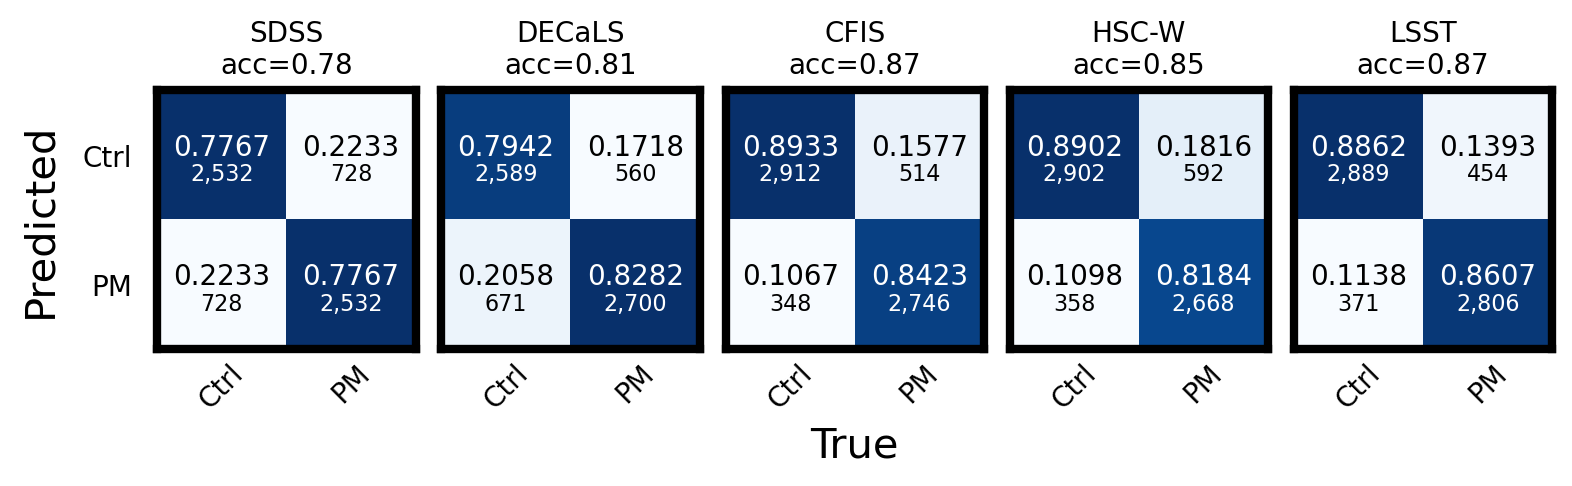

In [76]:
#Same-same confusion matrices
fig,axs = plt.subplots(1,5,figsize=[9,2],dpi=200)
axs = axs.flatten()
#sdss panel 0
cm = confusion_matrix(y_test,np.around(p_sdss))
ax_confusion_matrix(cm,axs[0],['Ctrl','PM'],do_y=True,normalize=True)
axs[0].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False)
axs[0].set_title('SDSS\nacc=0.78',fontsize=10)
#deca panel 1
cm = confusion_matrix(y_test,np.around(p_deca))
ax_confusion_matrix(cm,axs[1],['Ctrl','PM'],normalize=True)
axs[1].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False)
axs[1].set_title('DECaLS\nacc=0.81',fontsize=10)
#cfis panel 2
cm = confusion_matrix(y_test,np.around(p_cfis))
ax_confusion_matrix(cm,axs[2],['Ctrl','PM'],normalize=True)
axs[2].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False)
axs[2].set_title('CFIS\nacc=0.87',fontsize=10)
#hscw panel 3
cm = confusion_matrix(y_test,np.around(p_hscw))
ax_confusion_matrix(cm,axs[3],['Ctrl','PM'],normalize=True)
axs[3].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False)
axs[3].set_title('HSC-W\nacc=0.85',fontsize=10)
#eucl panel 4
# cm = confusion_matrix(y_test,np.around(p_eucl))
# ax_confusion_matrix(cm,axs[3],['Ctrl','PM'],do_y=True,normalize=True)
# axs[3].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False)
# axs[3].set_title('Euclid',fontsize=15)
#lsst panel 5
cm = confusion_matrix(y_test,np.around(p_lsst))
ax_confusion_matrix(cm,axs[4],['Ctrl','PM'],normalize=True)
axs[4].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False)
axs[4].set_title('LSST\nacc=0.87',fontsize=10)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('True', labelpad=20,fontsize=15) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('Predicted', labelpad=35,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.show()

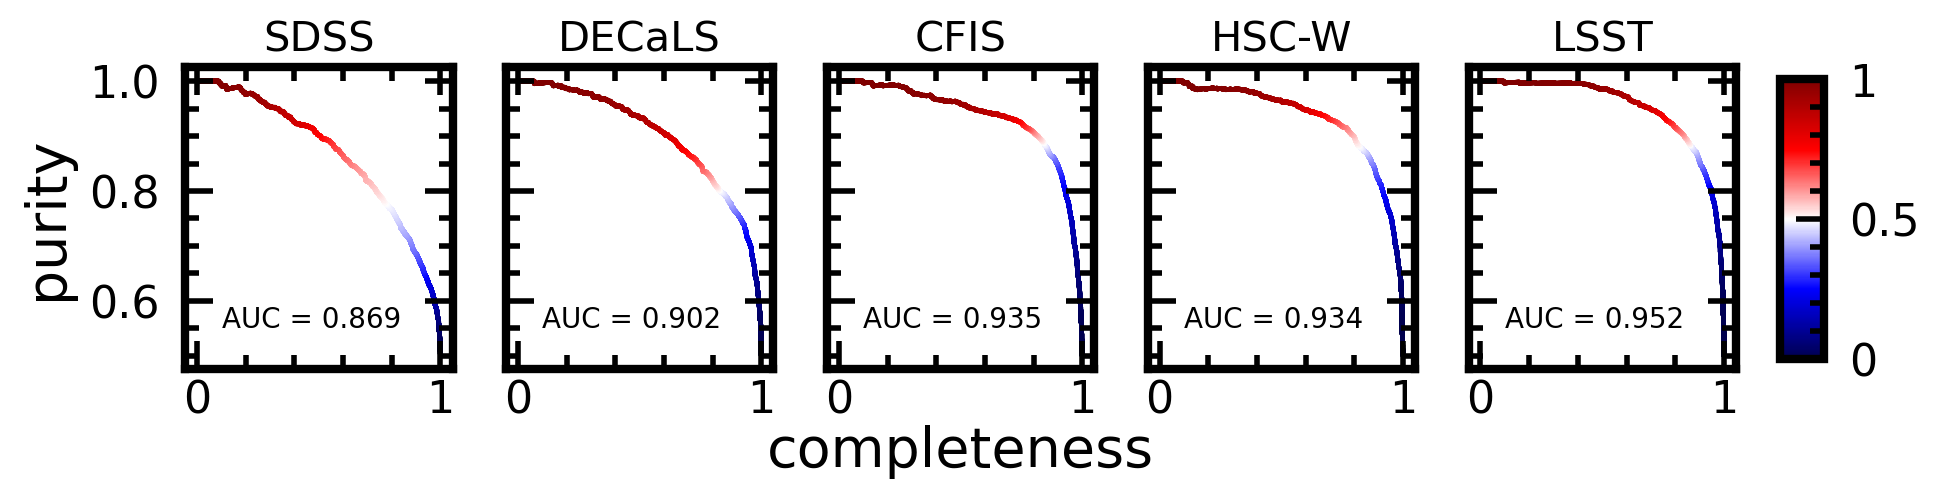

In [9]:
#Same-same PRC
fig,axs = plt.subplots(1,5,figsize=[11,2],dpi=200)
axs = axs.flatten()
#sdss panel 0
precision, recall, thresholds = precision_recall_curve(y_test,p_sdss)
axs[0].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
axs[0].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
axs[0].set_title('SDSS',fontsize=15)
#deca panel 1
precision, recall, thresholds = precision_recall_curve(y_test,p_deca)
axs[1].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
axs[1].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
axs[1].tick_params(labelleft=False)
axs[1].set_title('DECaLS',fontsize=15)
#cfis panel 2
precision, recall, thresholds = precision_recall_curve(y_test,p_cfis)
axs[2].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
axs[2].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
axs[2].tick_params(labelleft=False)
axs[2].set_title('CFIS',fontsize=15)
#hscw panel 3
precision, recall, thresholds = precision_recall_curve(y_test,p_hscw)
axs[3].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
axs[3].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
axs[3].tick_params(labelleft=False)
axs[3].set_title('HSC-W',fontsize=15)
#eucl panel 3
# precision, recall, thresholds = precision_recall_curve(y_test,p_eucl)
# axs[3].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
# axs[3].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
# #axs[3].tick_params(labelleft=False)
# axs[3].set_title('Euclid',fontsize=15)
#lsst panel 4
precision, recall, thresholds = precision_recall_curve(y_test,p_lsst)
a = axs[4].scatter(recall[:-1],precision[:-1],c=thresholds,cmap='seismic',s=0.5)
axs[4].text(0.1,0.55,'AUC = {:0.3f}'.format(auc(recall,precision)))
axs[4].tick_params(labelleft=False)
axs[4].set_title('LSST',fontsize=15)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('completeness', labelpad=20,fontsize=20) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('purity', labelpad=40,fontsize=20)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(a, cax=cbar_ax)
cbar_ax.set_yticks([0,0.5,1])
cbar_ax.set_yticklabels([0,0.5,1])

plt.subplots_adjust(wspace=0.2)
plt.show()

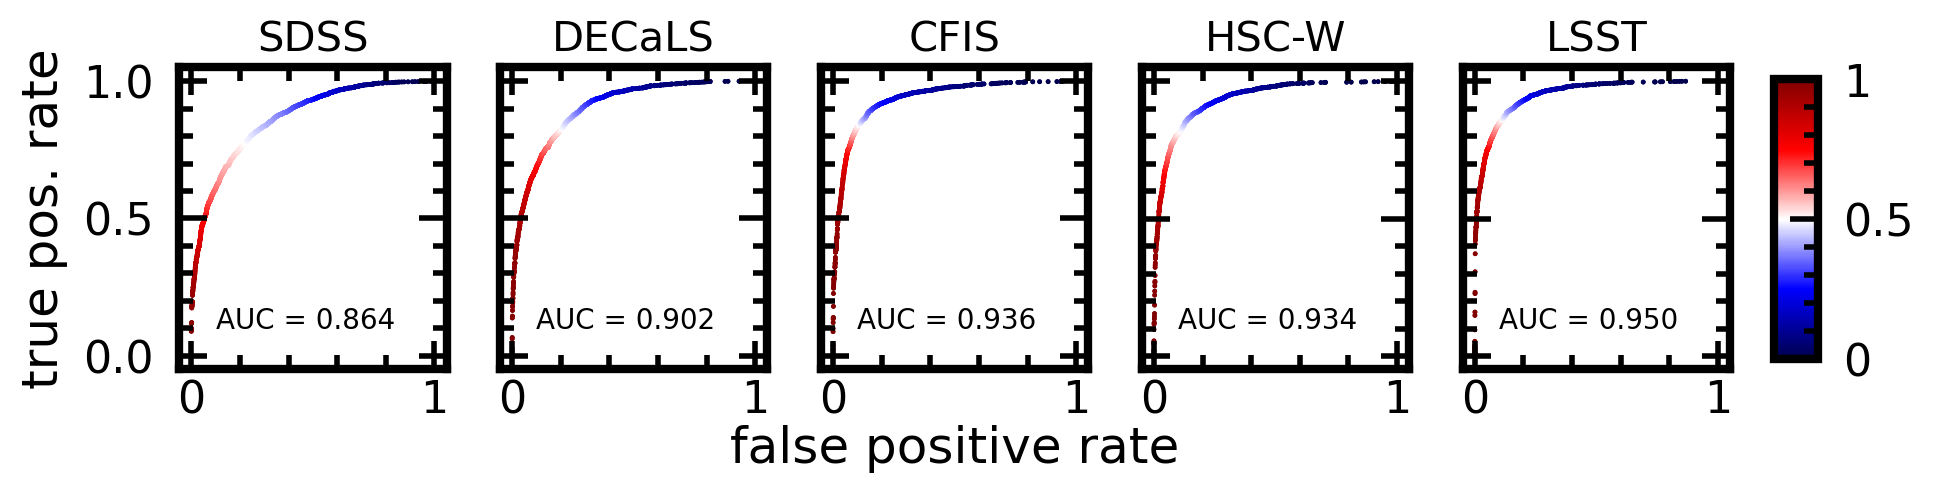

In [10]:
#same-same ROCs
fig,axs = plt.subplots(1,5,figsize=[11,2],dpi=200)
axs = axs.flatten()
#sdss panel 0
fpr, tpr, thresholds = roc_curve(y_test,p_sdss,pos_label=1)
axs[0].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
axs[0].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
axs[0].set_title('SDSS',fontsize=15)
#deca panel 1
fpr, tpr, thresholds = roc_curve(y_test,p_deca,pos_label=1)
axs[1].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
axs[1].tick_params(labelleft=False)
axs[1].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
axs[1].set_title('DECaLS',fontsize=15)
#cfis panel 2
fpr, tpr, thresholds = roc_curve(y_test,p_cfis,pos_label=1)
axs[2].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
axs[2].tick_params(labelleft=False)
axs[2].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
axs[2].set_title('CFIS',fontsize=15)
#hscwe panel 3
fpr, tpr, thresholds = roc_curve(y_test,p_hscw,pos_label=1)
axs[3].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
axs[3].tick_params(labelleft=False)
axs[3].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
axs[3].set_title('HSC-W',fontsize=15)
#eucl panel 3
# fpr, tpr, thresholds = roc_curve(y_test,p_eucl,pos_label=1)
# axs[3].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
# #axs[3].tick_params(labelleft=False)
# axs[3].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
# axs[3].set_title('Euclid',fontsize=15)
#lsst panel 4
fpr, tpr, thresholds = roc_curve(y_test,p_lsst,pos_label=1)
a = axs[4].scatter(fpr[1:],tpr[1:],c=thresholds[1:],cmap='seismic',s=0.5)
axs[4].tick_params(labelleft=False)
axs[4].text(0.1,0.1,'AUC = {:0.3f}'.format(auc(fpr,tpr)))
axs[4].set_title('LSST',fontsize=15)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('false positive rate', labelpad=20,fontsize=18) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('true pos. rate', labelpad=40,fontsize=18)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(a, cax=cbar_ax)
cbar_ax.set_yticks([0,0.5,1])
cbar_ax.set_yticklabels([0,0.5,1])

plt.subplots_adjust(wspace=0.2)
plt.show()

In [11]:
z_test = np.tile(np.repeat(z_grid,4),326)
print(z_test)

[0.036 0.036 0.036 ... 0.256 0.256 0.256]


In [12]:
#z_xerr = np.array([0.036, 0.101, 0.15, 0.198, 0.256])
z_xerr = [0.036,0.029,0.02,0.028,0.03]

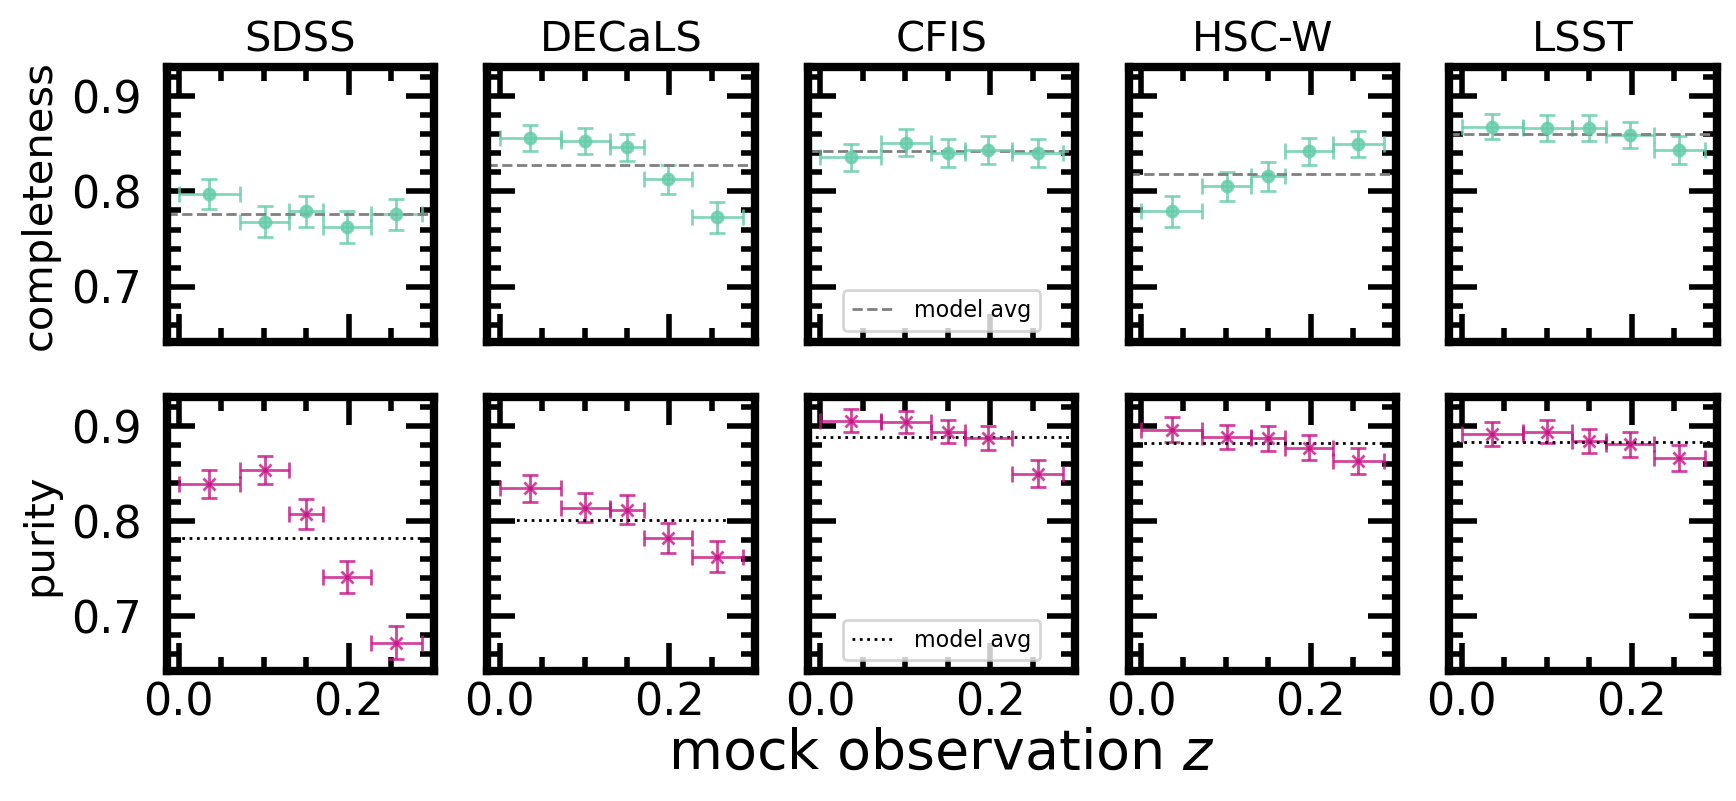

In [20]:
#acc v redshift for all surveys
fig,axs = plt.subplots(2,5,figsize=[10,4],sharex=True,sharey=True,dpi=200)
axs = axs.flatten()
#SDSS
stats = []
for i in range(5):
    ps = np.around(p_sdss[z_test==z_grid[i]])
    ys = y_test[z_test==z_grid[i]]
    # #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    # #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    #purities
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
#axs[0].fill_between(z_grid,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumaquamarine',alpha=0.5)
axs[0].errorbar(z_grid,stats[:,0],yerr=stats[:,1],xerr=z_xerr,marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',alpha=0.8,capsize=3)
axs[5].errorbar(z_grid,stats[:,2],yerr=stats[:,3],xerr=z_xerr,marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',alpha=0.8,capsize=3)
#axs[0].errorbar(z_grid,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Ctrl')
axs[0].axhline(np.mean(stats[:,0]),label='avg completeness',color='gray',linestyle='dashed',linewidth=1)
axs[5].axhline(np.mean(stats[:,2]),label='avg purity',color='black',linestyle='dotted',linewidth=1)

axs[0].set_title('SDSS',fontsize=15)

#DECaLS
stats = []
for i in range(5):
    ps = np.around(p_deca[z_test==z_grid[i]])
    ys = y_test[z_test==z_grid[i]]
    # #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    # #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    #purities
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
#axs[0].fill_between(z_grid,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumaquamarine',alpha=0.5)
axs[1].errorbar(z_grid,stats[:,0],yerr=stats[:,1],xerr=z_xerr,marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Completeness',alpha=0.8,capsize=3)
axs[6].errorbar(z_grid,stats[:,2],yerr=stats[:,3],xerr=z_xerr,marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Purity',alpha=0.8,capsize=3)
#axs[0].errorbar(z_grid,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Ctrl')
axs[1].axhline(np.mean(stats[:,0]),label='avg compl',color='gray',linestyle='dashed',linewidth=1)
axs[6].axhline(np.mean(stats[:,2]),label='avg pur',color='black',linestyle='dotted',linewidth=1)
axs[1].set_title('DECaLS',fontsize=15)
#CFIS
stats = []
for i in range(5):
    ps = np.around(p_cfis[z_test==z_grid[i]])
    ys = y_test[z_test==z_grid[i]]
    # #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    # #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    #purities
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
#axs[0].fill_between(z_grid,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumaquamarine',alpha=0.5)
#axs[0].errorbar(z_grid,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Ctrl')
axs[2].axhline(np.mean(stats[:,0]),label='model avg',color='gray',linestyle='dashed',linewidth=1)
axs[7].axhline(np.mean(stats[:,2]),label='model avg',color='black',linestyle='dotted',linewidth=1)
axs[2].set_title('CFIS',fontsize=15)
axs[2].legend(fontsize=8,loc='lower center')
axs[7].legend(fontsize=8,loc='lower center')
axs[2].errorbar(z_grid,stats[:,0],yerr=stats[:,1],xerr=z_xerr,marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',alpha=0.8,capsize=3)
axs[7].errorbar(z_grid,stats[:,2],yerr=stats[:,3],xerr=z_xerr,marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',alpha=0.8,capsize=3)

#HSC-W
stats = []
for i in range(5):
    ps = np.around(p_hscw[z_test==z_grid[i]])
    ys = y_test[z_test==z_grid[i]]
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
axs[3].errorbar(z_grid,stats[:,0],yerr=stats[:,1],xerr=z_xerr,marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Completeness',alpha=0.8,capsize=3)
axs[8].errorbar(z_grid,stats[:,2],yerr=stats[:,3],xerr=z_xerr,marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Purity',alpha=0.8,capsize=3)
axs[3].axhline(np.mean(stats[:,0]),label='avg compl',color='gray',linestyle='dashed',linewidth=1)
axs[8].axhline(np.mean(stats[:,2]),label='avg pur',color='black',linestyle='dotted',linewidth=1)
axs[3].set_title('HSC-W',fontsize=15)
#LSST
stats = []
for i in range(5):
    ps = np.around(p_lsst[z_test==z_grid[i]])
    ys = y_test[z_test==z_grid[i]]
    # #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    # #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    #purities
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
#axs[0].fill_between(z_grid,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumvioletred',alpha=0.5)
#axs[0].fill_between(z_grid,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumaquamarine',alpha=0.5)
axs[4].errorbar(z_grid,stats[:,0],yerr=stats[:,1],xerr=z_xerr,marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Completeness',alpha=0.8,capsize=3)
axs[9].errorbar(z_grid,stats[:,2],yerr=stats[:,3],xerr=z_xerr,marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Purity',alpha=0.8,capsize=3)
#axs[0].errorbar(z_grid,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='Ctrl')
axs[4].axhline(np.mean(stats[:,0]),label='avg Compl',color='gray',linestyle='dashed',linewidth=1)
axs[9].axhline(np.mean(stats[:,2]),label='avg Pur',color='black',linestyle='dotted',linewidth=1)
axs[4].set_title('LSST',fontsize=15)
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('mock observation $z$', labelpad=20,fontsize=20) # Use argument `labelpad` to move label downwards.
axs[0].set_ylabel('completeness',fontsize=15)
axs[5].set_ylabel('purity',fontsize=15)

plt.show()

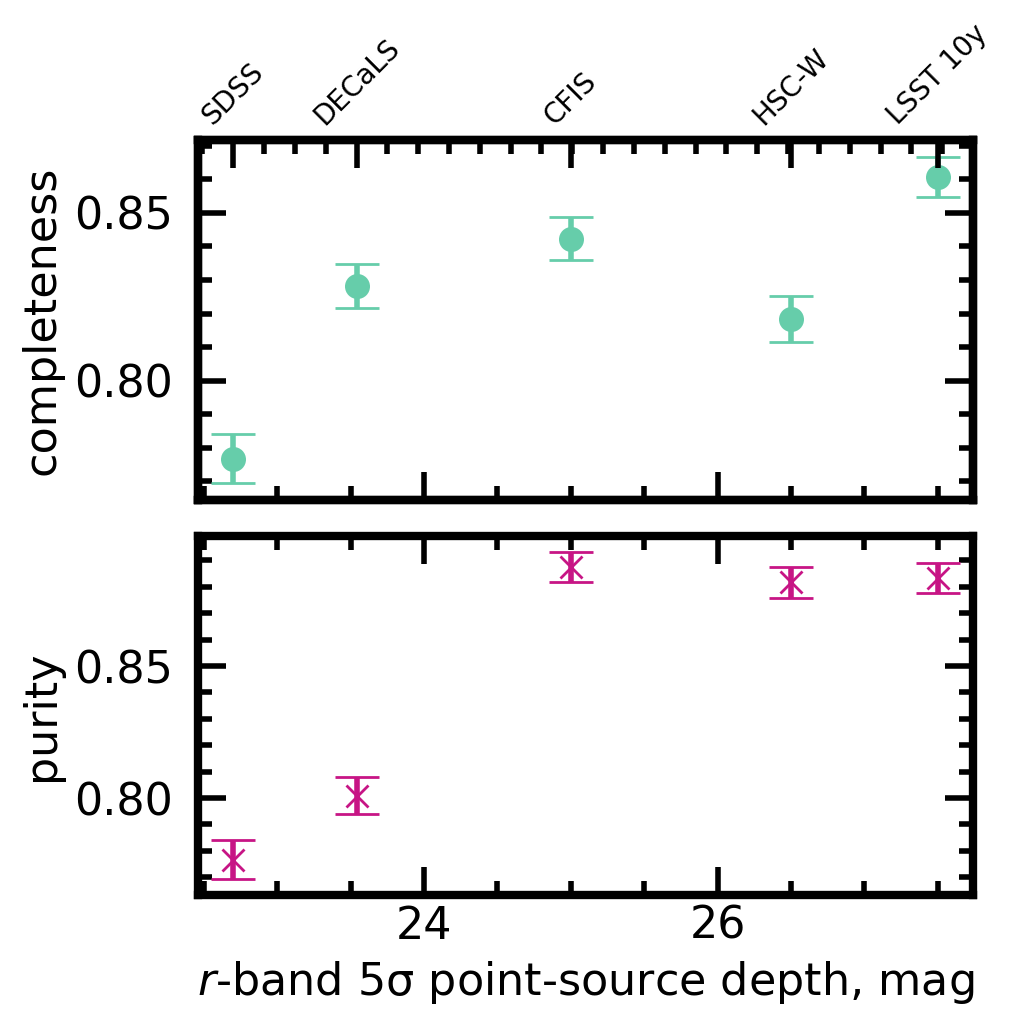

In [10]:
depths = five_sig_psd

fig,axs = plt.subplots(2,1,figsize=[5,5],dpi=200,sharex=True)
preds_all = [np.around(p_sdss),np.around(p_deca),np.around(p_cfis),np.around(p_hscw),np.around(p_lsst)]
ys_all = [y_test,y_test,y_test,y_test,y_test,y_test]
#accs_tot = np.array([len(p[p==y])/len(p) for p,y in zip(preds_all,ys_all)])
#errs_tot = np.sqrt(accs_tot*(1-accs_tot)/len(y_test))
accs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[y==1]) for p,y in zip(preds_all,ys_all)])
errs_pos = np.sqrt(accs_pos*(1-accs_pos)/len(y_test[y_test==1]))
#accs_neg = np.array([len(p[(p==y)&(y==0)])/len(p[y==0]) for p,y in zip(preds_all,ys_all)])
#errs_neg = np.sqrt(accs_neg*(1-accs_neg)/len(y_test[y_test==0]))
purs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[p==1]) for p,y in zip(preds_all,ys_all)])
perrs_pos = np.array([np.sqrt(pu*(1-pu)/len(y_test[p==1])) for pu,p in zip(purs_pos,preds_all)])

#axs.fill_between(depths,accs_tot-errs_tot,accs_tot+errs_tot,color='gray',alpha=0.5)
#axs.fill_between(depths,accs_pos-errs_pos,accs_pos+errs_pos,color='mediumaquamarine',alpha=0.5)
#axs.fill_between(depths,accs_neg-errs_neg,accs_neg+errs_neg,color='mediumvioletred',alpha=0.5)
#axs.errorbar(depths,accs_tot,yerr=errs_tot,marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[0].errorbar(depths,accs_pos,yerr=errs_pos,marker='o',linestyle='None',color='mediumaquamarine',markersize=8,linewidth=2,label='completeness',capsize=8)
axs[1].errorbar(depths,purs_pos,yerr=perrs_pos,marker='x',linestyle='None',color='mediumvioletred',markersize=8,linewidth=2,label='purity',capsize=8)
plt.xlabel('$r$-band 5$\mathrm{\sigma}$ point-source depth, mag')
axs[0].set_ylabel('completeness')
axs[1].set_ylabel('purity')

ax2 = axs[0].twiny()
ax2.set_xlim(axs[0].get_xlim())
ax2.set_xticks(depths)
ax2.set_xticklabels(surveys,rotation=45,fontsize=10)
plt.subplots_adjust(hspace=0.1)
plt.show()

# Accuracy versus depth

The main trend uncovered in this work is the sensitivity of CNNs to imaging depth for merger identification tasks. When imaging depth is inadequate, the features that distinguish even major mergers from non-merging galaxies cannot always be seen, resulting in significant confusion between the classes. At much higher depth, there may be some confusion between merger and non-merger classes when diffuse substructure in non-merger galaxies gives the false appearance of a recent merger. However, models are capable of self-calibrating during training, and the loss is minimized in deep imaging since mergers and non-mergers can almost always be distinguished based on the relative brightness and shape of diffuse stellar morphology.

We arrange the five survey models trained in this work in order of increasing r-band noise standard deviation. As explored in Figure (CMXs), the best global and post-merger accuracies are reached in the deepest imaging. Meanwhile, the best performance on non-merger control galaxies is reached in CFIS, at intermediate depth. It is likely that CFIS imaging falls at a convenient S/N level, where the sky noise preferentially obscures any low-SB irregular morphology in non-mergers, while generally preserving the appearance of true merger-induced irregular structure.

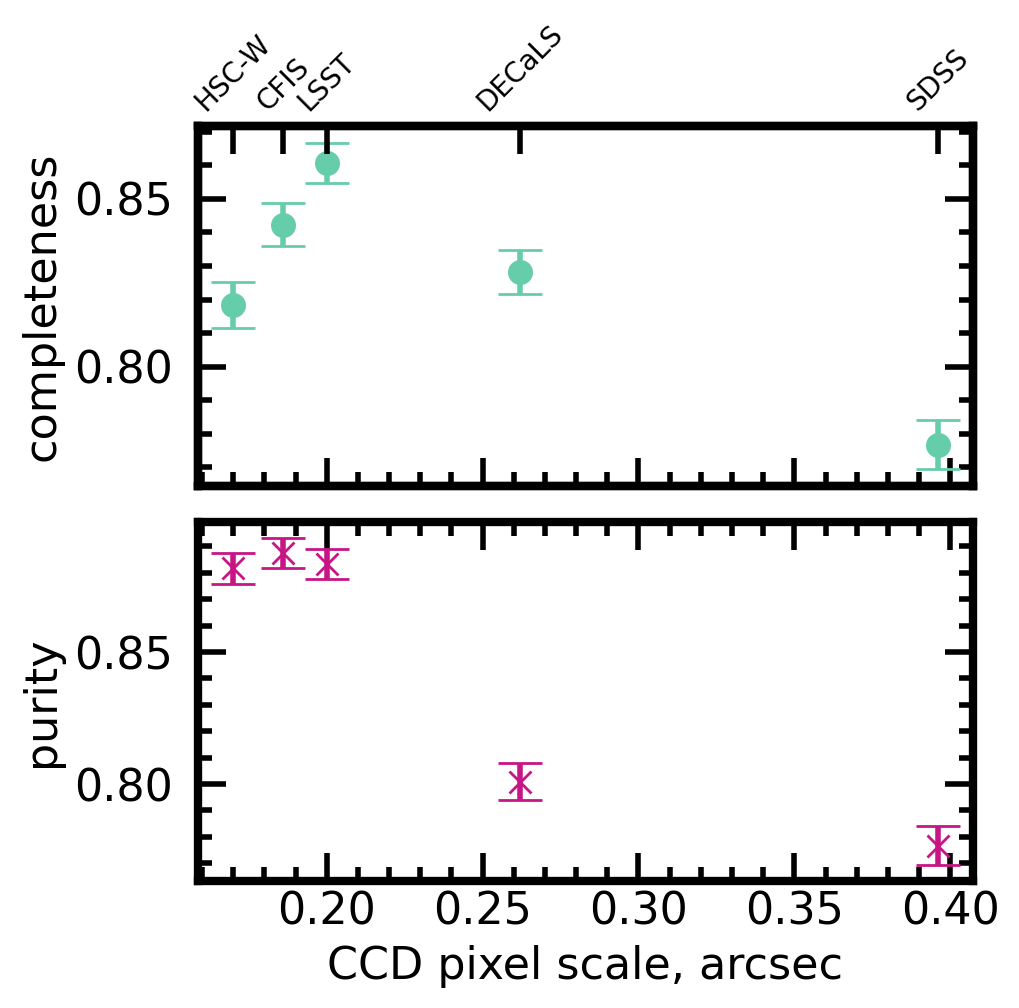

In [9]:
fig,axs = plt.subplots(2,1,figsize=[5,5],dpi=200,sharex=True)
CCDs = [0.396,0.262,0.2,0.186,0.17]
preds_all = [np.around(p_sdss),np.around(p_deca),np.around(p_lsst),np.around(p_cfis),np.around(p_hscw)]
ys_all = [y_test,y_test,y_test,y_test,y_test,y_test]
accs_tot = np.array([len(p[p==y])/len(p) for p,y in zip(preds_all,ys_all)])
errs_tot = np.sqrt(accs_tot*(1-accs_tot)/len(y_test))
accs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[y==1]) for p,y in zip(preds_all,ys_all)])
errs_pos = np.sqrt(accs_pos*(1-accs_pos)/len(y_test[y_test==1]))
accs_neg = np.array([len(p[(p==y)&(y==0)])/len(p[y==0]) for p,y in zip(preds_all,ys_all)])
errs_neg = np.sqrt(accs_neg*(1-accs_neg)/len(y_test[y_test==0]))

purs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[p==1]) for p,y in zip(preds_all,ys_all)])
perrs_pos = np.array([np.sqrt(pu*(1-pu)/len(y_test[p==1])) for pu,p in zip(purs_pos,preds_all)])

#axs.fill_between(CCDs,accs_tot-errs_tot,accs_tot+errs_tot,color='gray',alpha=0.5)
#axs.fill_between(CCDs,accs_pos-errs_pos,accs_pos+errs_pos,color='mediumaquamarine',alpha=0.5)
#axs.fill_between(CCDs,accs_neg-errs_neg,accs_neg+errs_neg,color='mediumvioletred',alpha=0.5)
#axs.errorbar(CCDs,accs_tot,yerr=errs_tot,marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[0].errorbar(CCDs,accs_pos,yerr=errs_pos,marker='o',linestyle='None',color='mediumaquamarine',markersize=8,linewidth=2,label='completeness',capsize=8)
axs[1].errorbar(CCDs,purs_pos,yerr=perrs_pos,marker='x',linestyle='None',color='mediumvioletred',markersize=8,linewidth=2,label='purity',capsize=8)
plt.xlabel('CCD pixel scale, arcsec')
axs[0].set_ylabel('completeness')
axs[1].set_ylabel('purity')

#surveys2 = ['Euclid','HSC-W','CFIS','Rubin 10yr','DECaLS','SDSS']
surveys2 = ['SDSS','DECaLS','LSST','CFIS','HSC-W']
ax2 = axs[0].twiny()
ax2.set_xlim(axs[0].get_xlim())
ax2.set_xticks(CCDs)
ax2.set_xticklabels(surveys2,rotation=45,fontsize=10)
plt.subplots_adjust(hspace=0.1)
plt.show()

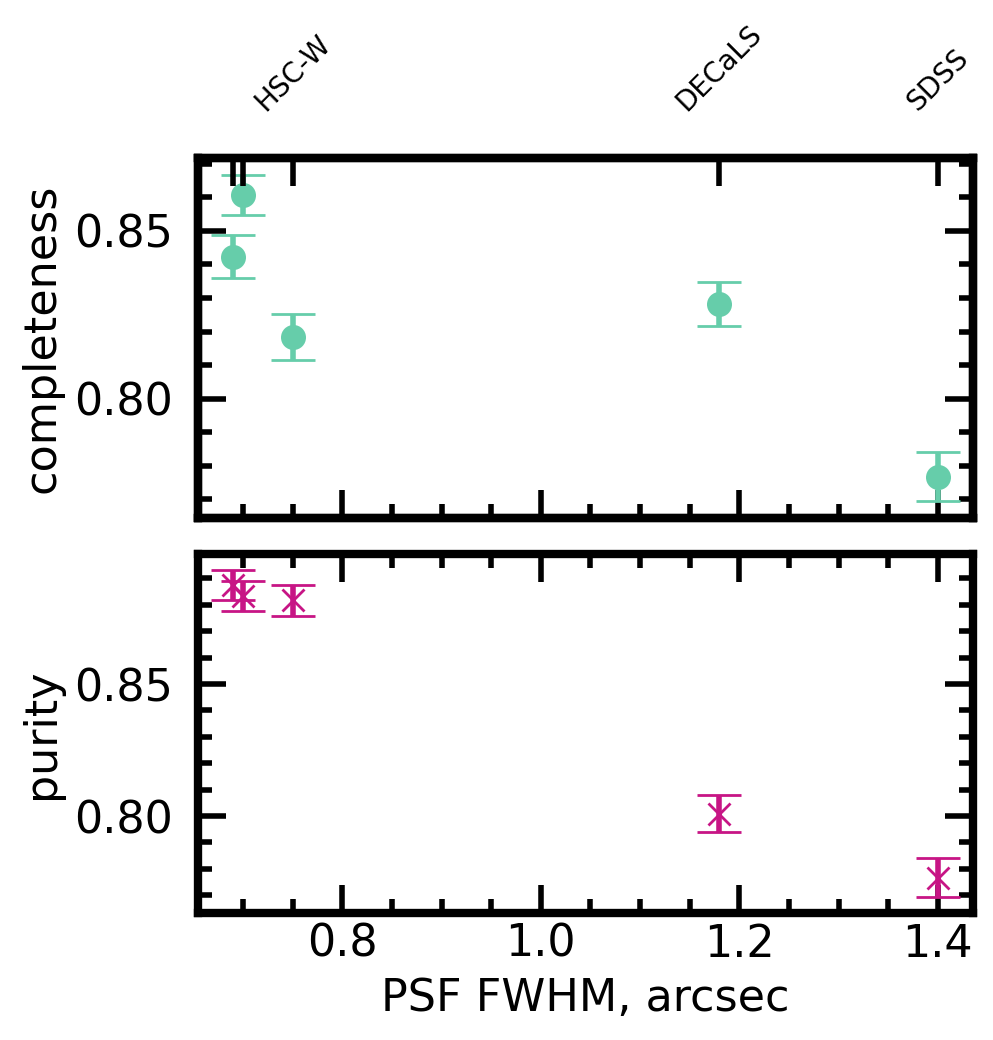

In [11]:
fig,axs = plt.subplots(2,1,figsize=[5,5],dpi=200,sharex=True)
depths = [1.4,1.18,0.75,0.7,0.69]
surveys2 = ['SDSS','DECaLS','HSC-W','','']#it's 'LSST', 'CFIS'
#surveys2 = ['SDSS','DECaLS','','','','Euclid']
y_sdss = y_test
preds_all = [np.around(p_sdss),np.around(p_deca),np.around(p_hscw),np.around(p_lsst),np.around(p_cfis)]
ys_all = [y_test,y_test,y_test,y_test,y_test,y_test]
accs_tot = np.array([len(p[p==y])/len(p) for p,y in zip(preds_all,ys_all)])
errs_tot = np.sqrt(accs_tot*(1-accs_tot)/len(y_sdss))
accs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[y==1]) for p,y in zip(preds_all,ys_all)])
errs_pos = np.sqrt(accs_pos*(1-accs_pos)/len(y_sdss[y_sdss==1]))
accs_neg = np.array([len(p[(p==y)&(y==0)])/len(p[y==0]) for p,y in zip(preds_all,ys_all)])
errs_neg = np.sqrt(accs_neg*(1-accs_neg)/len(y_sdss[y_sdss==0]))
purs_pos = np.array([len(p[(p==y)&(y==1)])/len(p[p==1]) for p,y in zip(preds_all,ys_all)])
perrs_pos = np.array([np.sqrt(pu*(1-pu)/len(y_test[p==1])) for pu,p in zip(purs_pos,preds_all)])

axs[0].errorbar(depths,accs_pos,yerr=errs_pos,marker='o',linestyle='None',color='mediumaquamarine',markersize=8,linewidth=2,capsize=8,label='completeness')
axs[1].errorbar(depths,purs_pos,yerr=perrs_pos,marker='x',linestyle='None',color='mediumvioletred',markersize=8,linewidth=2,capsize=8,label='purity')
plt.xlabel('PSF FWHM, arcsec')
axs[0].set_ylabel('completeness')
axs[1].set_ylabel('purity')

ax2 = axs[0].twiny()
ax2.set_xlim(axs[0].get_xlim())
ax2.set_xticks(depths)
ax2.tick_params(axis='x', which='major', pad=15)
ax2.set_xticklabels(surveys2,rotation=45,fontsize=10)
plt.subplots_adjust(hspace=0.1)
plt.show()

In [5]:
data_dir = '/arc/projects/MachineLearning/Bobby/obs_proj_dat/'
df = pd.read_pickle(data_dir+'sample_catalog_pandas.pk')
df

DB_ID  snapNum  subfindID  N2            r1          rsep  \
19666   52_268551       52     268551  16  6.196300e+02  7.934000e+01   
26157   63_344894       63     344894   5  1.898400e+02  2.898000e+01   
28997   69_300684       69     300684   0  1.000000e+09  1.000000e+09   
30565   72_415412       72     415412   3  8.680700e+02  1.022000e+02   
37648   92_539769       92     539769   2  1.484210e+03  3.297300e+02   
...           ...      ...        ...  ..           ...           ...   
123566  88_427491       88     427491   1  1.534670e+03  2.681200e+02   
103714  83_339946       83     339946   4  3.082800e+02  4.917000e+01   
124586  88_486500       88     486500   1  1.384090e+03  9.048000e+01   
46456    66_67843       66      67843  26  3.698300e+02  1.646000e+01   
23559   59_316851       59     316851   1  1.937130e+03  4.389300e+02   

        Redshift  Tlookback  Tpostmerger  MassRatio  ...  \
19666   0.923001    7.60903      0.00000   0.192085  ...   
26157   0.598543    5.87102      0.00000   0.422258  ...   
28997   0.460918    4.90085      0.00000   0.187594  ...   
30565   0.399927    4.41345      0.00000   0.583266  ...   
37648   0.083884    1.14008      0.00000   0.490848  ...   
...          ...        ...          ...        ...  ...   
123566  0.141876    1.85204      8.50196   0.000000  ...   
103714  0.214425    2.66510      4.78122   0.976532  ...   
124586  0.141876    1.85204      2.72584   0.142288  ...   
46456   0.524566    5.37044      4.98356   0.000000  ...   
23559   0.700106    6.48817      3.86582   0.000000  ...   

        SubhaloMassInRadType_gas   r1_new   r2_new  N2_new  gas_frac  \
19666                    8.17454   390.76   416.50      40  0.004028   
26157                    9.67023   189.84   524.14       7  0.393849   
28997                    9.19145   977.90  1653.03       2  0.017292   
30565                    9.57939   868.07   912.19       3  0.308241   
37648                    9.31126  1484.21  1775.69       3  0.185251   
...                          ...      ...      ...     ...       ...   
123566                   8.52330   123.10   869.96       4  0.012031   
103714                   8.81228    76.25   178.63      12  0.010223   
124586                   9.89105  1384.09  1696.90       2  0.574844   
46456                    8.16283   350.73   369.83      52  0.003497   
23559                    7.51931   981.76  1063.90      13  0.000919   

        merger_label  merger_bin_label  control_IDS    label  snap_label  
19666             pm               1.0    52_190785   merger         0.0  
26157             pm               1.0    63_416879   merger         0.0  
28997             pm               1.0    69_280742   merger         0.0  
30565             pm               1.0    72_471572   merger         0.0  
37648             pm               1.0    92_471817   merger         0.0  
...              ...               ...          ...      ...         ...  
123566           NaN               NaN    88_427491  control         NaN  
103714           NaN               NaN    83_339946  control         NaN  
124586           NaN               NaN    88_486500  control         NaN  
46456            NaN               NaN     66_67843  control         NaN  
23559            NaN               NaN    59_316851  control         NaN  

[3254 rows x 29 columns]

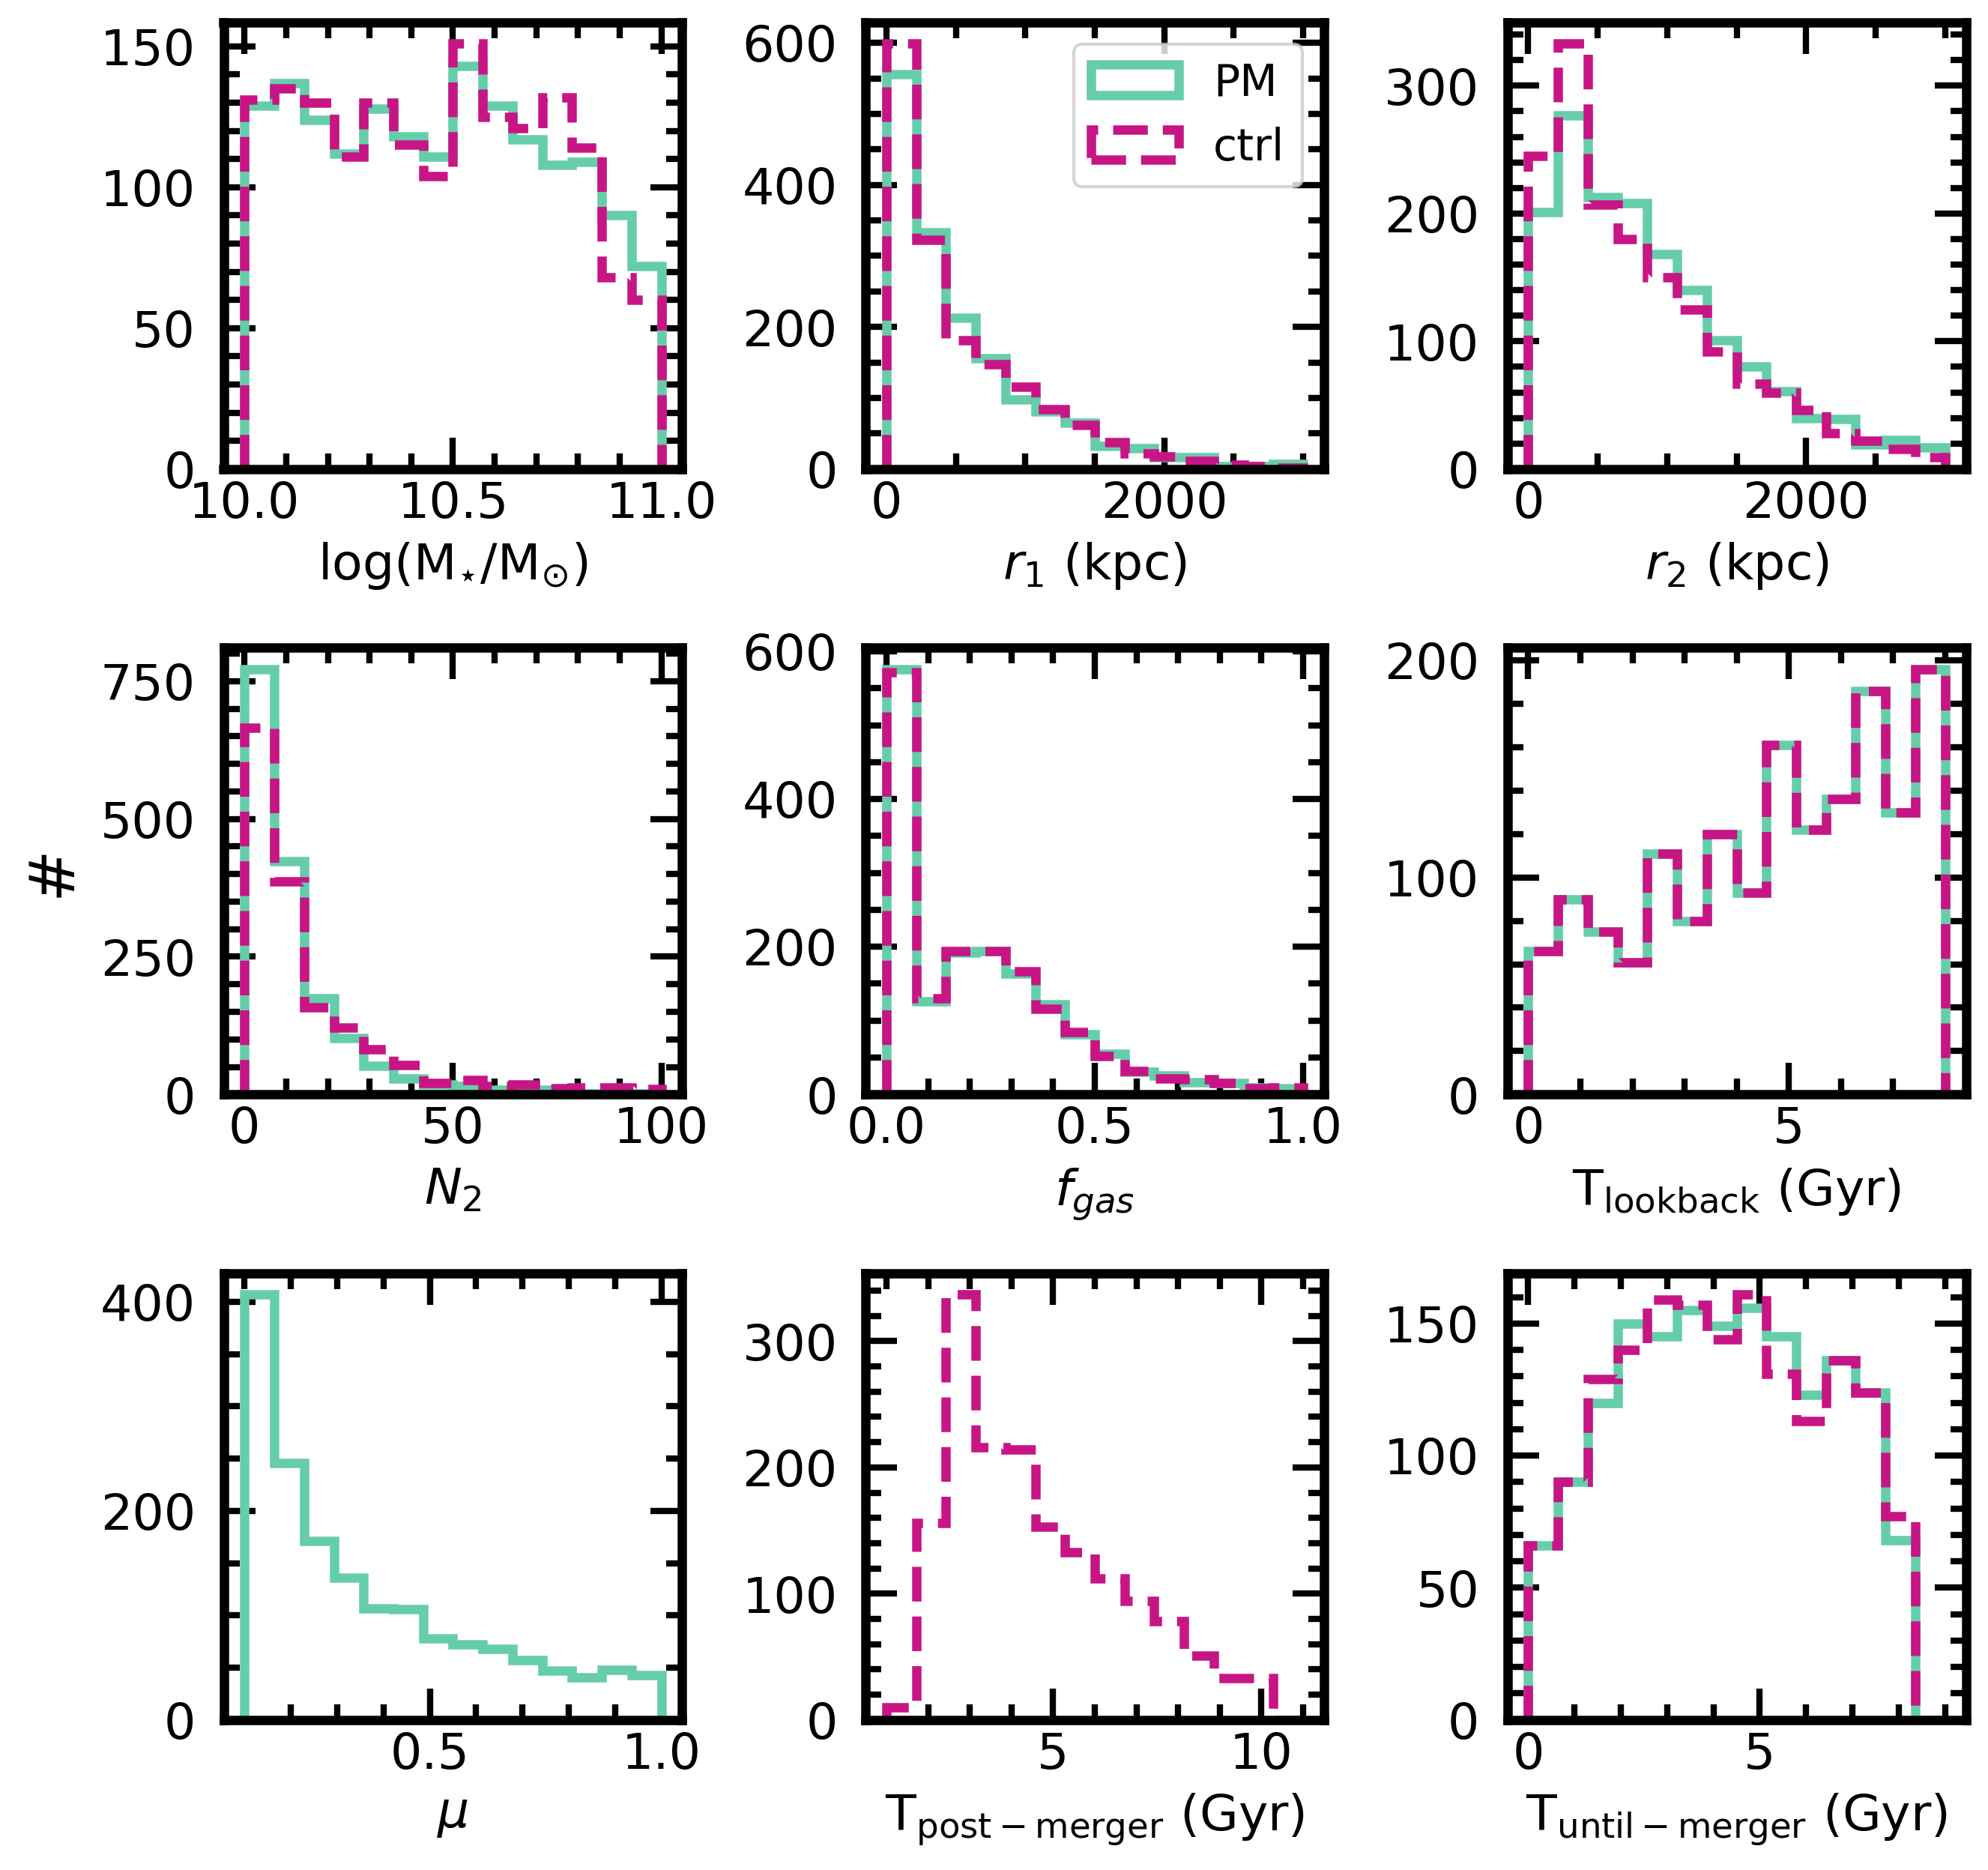

In [6]:
fig,axs = plt.subplots(3,3,figsize=[10,10],dpi=300)
axs[0,0].hist(df.SubhaloMassInRadType_stars[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(10,11,15))
axs[0,0].hist(df.SubhaloMassInRadType_stars[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(10,11,15),linestyle='dashed')
axs[0,0].set_xlabel('log($\mathrm{M_{\star}/M_{\odot}}$)')

axs[0,1].hist(df.r1_new[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,3000,15))
axs[0,1].hist(df.r1_new[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,3000,15),linestyle='dashed')
axs[0,1].legend()
axs[0,1].set_xlabel('$r_{1}$ (kpc)')

axs[0,2].hist(df.r2_new[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,3000,15))
axs[0,2].hist(df.r2_new[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,3000,15),linestyle='dashed')
axs[0,2].set_xlabel('$r_{2}$ (kpc)')

axs[1,0].hist(df.N2_new[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,100,15))
axs[1,0].hist(df.N2_new[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,100,15),linestyle='dashed')
axs[1,0].set_xlabel('$N_{2}$')

axs[1,1].hist(df.gas_frac[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,1,15))
axs[1,1].hist(df.gas_frac[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,1,15),linestyle='dashed')
axs[1,1].set_xlabel('$f_{gas}$')

axs[1,2].hist(df.Tlookback[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,8,15))
axs[1,2].hist(df.Tlookback[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,8,15),linestyle='dashed')
axs[1,2].set_xlabel('$\mathrm{T_{lookback}}$ (Gyr)')

axs[2,0].hist(df.MassRatio[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0.1,1,15))
#axs[2,0].hist(df.MassRatio[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3)#,bins=np.linspace(0,8,15),linestyle='dashed')
axs[2,0].set_xlabel('$\mu$')

#axs[2,1].hist(df.Tpostmerger[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,11,15))
axs[2,1].hist(df.Tpostmerger[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(1,11,15),linestyle='dashed')
axs[2,1].set_xlabel('$\mathrm{T_{post-merger}}$ (Gyr)')

axs[2,2].hist(df.Tuntilmerger[df.label=='merger'],color='mediumaquamarine',label='PM',histtype='step',linewidth=3,bins=np.linspace(0,9,15))
axs[2,2].hist(df.Tuntilmerger[df.label=='control'],color='mediumvioletred',label='ctrl',histtype='step',linewidth=3,bins=np.linspace(0,9,15),linestyle='dashed')
axs[2,2].set_xlabel('$\mathrm{T_{until-merger}}$ (Gyr)')
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_ylabel('#', labelpad=45,fontsize=20)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

In [46]:
#plot performance versus TNG metadata characteristics

ids_pos = df[df['label']=='merger']['DB_ID'].tolist()
ids_neg = df[df['label']=='merger']['control_IDS'].tolist()
idp_train,idp_test,idn_train,idn_test = train_test_split(ids_pos,ids_neg,test_size=0.1,random_state=42)
idp_train,idp_val,idn_train,idn_val = train_test_split(idp_train,idn_train,test_size=0.11111,random_state=42)

DB_ID_new = []
for m_ID,c_ID in tqdm(zip(idp_test,idn_test),total=len(idp_test)):
    DB_ID_new.append(m_ID)
    DB_ID_new.append(c_ID)
DB_ID_new = np.repeat(DB_ID_new,20)
print(len(DB_ID_new))

  0%|          | 0/163 [00:00<?, ?it/s]

6520


In [47]:
test_df = pd.DataFrame({'DB_ID':DB_ID_new})
test_df = test_df.merge(df,on='DB_ID',how='left')
test_df

DB_ID  snapNum  subfindID  N2      r1   rsep  Redshift  Tlookback  \
0     69_295052       69     295052   5  164.18  14.58  0.460918    4.90085   
1     69_295052       69     295052   5  164.18  14.58  0.460918    4.90085   
2     69_295052       69     295052   5  164.18  14.58  0.460918    4.90085   
3     69_295052       69     295052   5  164.18  14.58  0.460918    4.90085   
4     69_295052       69     295052   5  164.18  14.58  0.460918    4.90085   
...         ...      ...        ...  ..     ...    ...       ...        ...   
6515   52_68181       52      68181  26  468.62  69.80  0.923001    7.60903   
6516   52_68181       52      68181  26  468.62  69.80  0.923001    7.60903   
6517   52_68181       52      68181  26  468.62  69.80  0.923001    7.60903   
6518   52_68181       52      68181  26  468.62  69.80  0.923001    7.60903   
6519   52_68181       52      68181  26  468.62  69.80  0.923001    7.60903   

      Tpostmerger  MassRatio  ...  SubhaloMassInRadType_gas  r1_new  r2_new  \
0         0.00000   0.220681  ...                  10.47290  157.05  164.18   
1         0.00000   0.220681  ...                  10.47290  157.05  164.18   
2         0.00000   0.220681  ...                  10.47290  157.05  164.18   
3         0.00000   0.220681  ...                  10.47290  157.05  164.18   
4         0.00000   0.220681  ...                  10.47290  157.05  164.18   
...           ...        ...  ...                       ...     ...     ...   
6515      2.74497   0.000000  ...                   9.67656  468.62  536.69   
6516      2.74497   0.000000  ...                   9.67656  468.62  536.69   
6517      2.74497   0.000000  ...                   9.67656  468.62  536.69   
6518      2.74497   0.000000  ...                   9.67656  468.62  536.69   
6519      2.74497   0.000000  ...                   9.67656  468.62  536.69   

      N2_new  gas_frac  merger_label  merger_bin_label  control_IDS    label  \
0         18  0.486071            pm               1.0    69_368027   merger   
1         18  0.486071            pm               1.0    69_368027   merger   
2         18  0.486071            pm               1.0    69_368027   merger   
3         18  0.486071            pm               1.0    69_368027   merger   
4         18  0.486071            pm               1.0    69_368027   merger   
...      ...       ...           ...               ...          ...      ...   
6515      41  0.305534           NaN               NaN     52_68181  control   
6516      41  0.305534           NaN               NaN     52_68181  control   
6517      41  0.305534           NaN               NaN     52_68181  control   
6518      41  0.305534           NaN               NaN     52_68181  control   
6519      41  0.305534           NaN               NaN     52_68181  control   

      snap_label  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
6515         NaN  
6516         NaN  
6517         NaN  
6518         NaN  
6519         NaN  

[6520 rows x 29 columns]

0.100097
0.999325


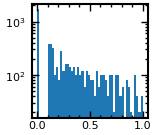

In [48]:
fig,axs = plt.subplots(figsize=[3,3],dpi=50)
plt.hist(test_df['MassRatio'],bins=50,log=True)
print(np.amin(test_df['MassRatio'][test_df['MassRatio']>0]))
print(np.amax(test_df['MassRatio'][test_df['MassRatio']>0]))

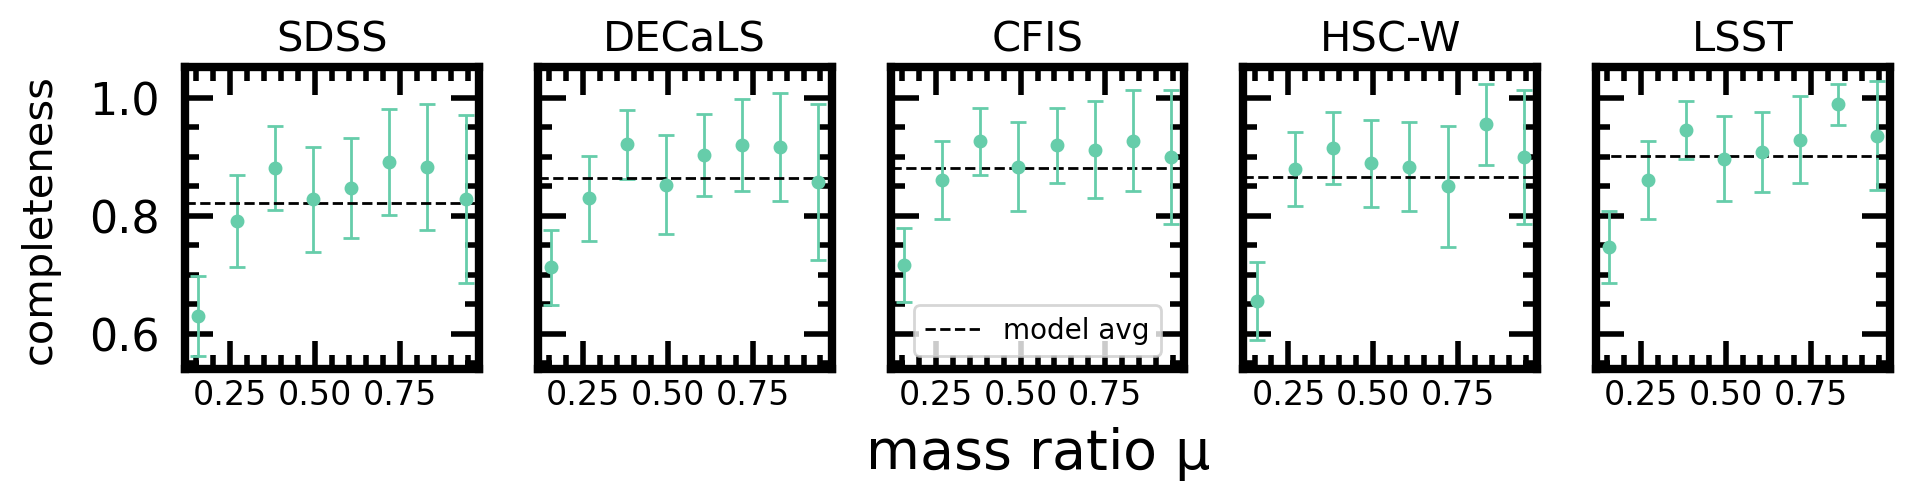

In [52]:
#acc v r1 for all four surveys
r1_test = test_df['MassRatio']
r1_grid = np.linspace(0.1,1,9)
fig,axs = plt.subplots(1,5,figsize=[11,2],sharex=True,sharey=True,dpi=200)
axs = axs.flatten()
#SDSS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_sdss[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/(den_pos/20))
    #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    stats.append([0,0,f_pos,err_pos,0,0])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[0].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[0].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,capsize=3,label='PM')
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=2,linewidth=0.5,label='Ctrl')
axs[0].axhline(np.mean(stats[:,2]),label='avg completeness',color='black',linestyle='dashed',linewidth=1)
axs[0].set_title('SDSS',fontsize=15)

#DECaLS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_deca[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/(den_pos/20))
    #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    stats.append([0,0,f_pos,err_pos,0,0])
stats = np.array(stats)
#axs[1].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[1].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[1].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[1].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[1].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,capsize=3,label='PM')
#axs[1].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=2,linewidth=0.5,label='Ctrl')
axs[1].axhline(np.mean(stats[:,2]),label='avg completeness',color='black',linestyle='dashed',linewidth=1)
axs[1].set_title('DECaLS',fontsize=15)
#CFIS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_cfis[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/(den_pos/20))
    #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    stats.append([0,0,f_pos,err_pos,0,0])
stats = np.array(stats)
#axs[2].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[2].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[2].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[2].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
#axs[2].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=2,linewidth=0.5,label='Ctrl')
axs[2].axhline(np.mean(stats[:,2]),label='model avg',color='black',linestyle='dashed',linewidth=1)
axs[2].set_title('CFIS',fontsize=15)
axs[2].legend(fontsize=10,loc='lower center')
axs[2].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,capsize=3,label='completeness')
#HSC-W
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_hscw[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/(den_pos/20))
    #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    stats.append([0,0,f_pos,err_pos,0,0])
stats = np.array(stats)
#axs[3].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[4].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[3].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[3].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[3].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,capsize=3,label='PM')
#axs[3].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=2,linewidth=0.5,label='Ctrl')
axs[3].axhline(np.mean(stats[:,2]),label='avg completeness',color='black',linestyle='dashed',linewidth=1)
axs[3].set_title('HSC-W',fontsize=15)
#LSST
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_lsst[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #totals
    # num_tot = len(ps[ps==ys])
    # den_tot = len(ps)
    # f_tot = num_tot/den_tot
    # err_tot = np.sqrt(f_tot*(1-f_tot)/den_tot)
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/(den_pos/20))
    # #controls
    # num_neg = len(ps[(ps==ys)&(ys==0)])
    # den_neg = len(ps[(ys==0)])
    # f_neg = num_neg/den_neg
    # err_neg = np.sqrt(f_neg*(1-f_neg)/den_neg)
    stats.append([0,0,f_pos,err_pos,0,0])
stats = np.array(stats)
#axs[4].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[5].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[4].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[4].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],marker='o',linestyle='None',color='black',markersize=2,linewidth=0.5,label='all')
axs[4].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,capsize=3,label='PM')
#axs[4].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=2,linewidth=0.5,label='Ctrl')
axs[4].axhline(np.mean(stats[:,2]),label='avg completeness',color='black',linestyle='dashed',linewidth=1)
axs[4].set_title('LSST',fontsize=15)

for ax in axs.flatten():
    ax.tick_params(axis='x', which='major', labelsize=12)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('mass ratio $\mathrm{\mu}$', labelpad=20,fontsize=20) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('completeness', labelpad=45,fontsize=15)

plt.show()

440
420
340
360
540
460
400
300
[10.0625 10.1875 10.3125 10.4375 10.5625 10.6875 10.8125 10.9375]
[10.0625 10.1875 10.3125 10.4375 10.5625 10.6875 10.8125 10.9375]
[10.0625 10.1875 10.3125 10.4375 10.5625 10.6875 10.8125 10.9375]
[10.0625 10.1875 10.3125 10.4375 10.5625 10.6875 10.8125 10.9375]
[10.0625 10.1875 10.3125 10.4375 10.5625 10.6875 10.8125 10.9375]


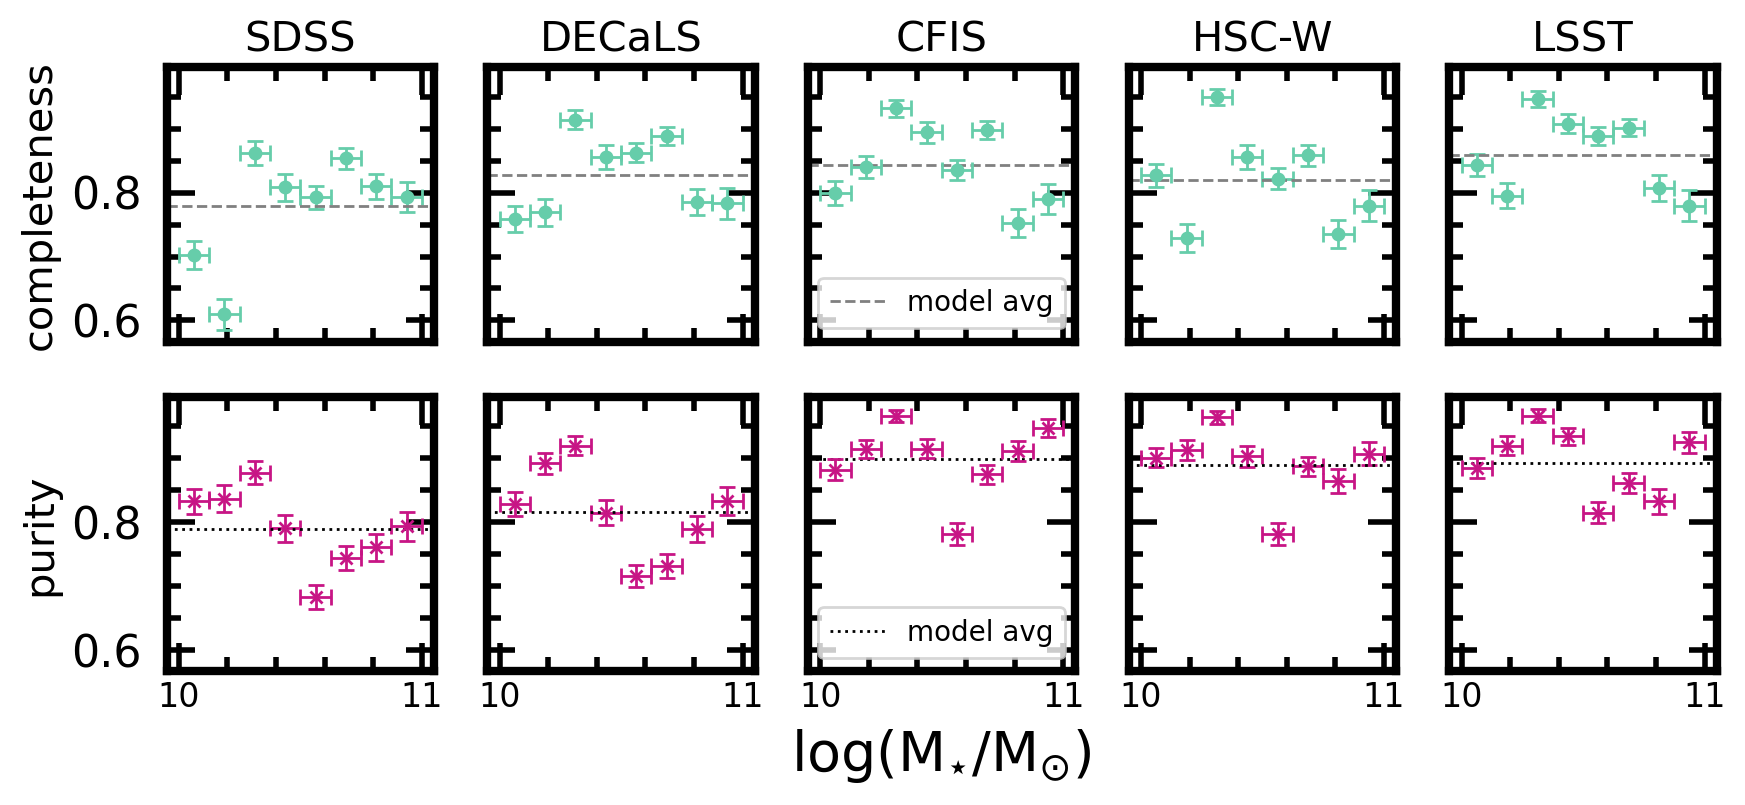

In [54]:
#acc v r1 for all four surveys
r1_test = test_df['SubhaloMassInRadType_stars']
r1_grid = np.linspace(10,11,9)
fig,axs = plt.subplots(2,5,figsize=[10,4],sharex=True,sharey=True,dpi=200)
axs = axs.flatten()
#SDSS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_sdss[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    print(den_pos)
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    #pur
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
print(r1_plot)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
axs[0].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],xerr=r1_plot-r1_grid[:-1],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',capsize=3)
axs[5].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],xerr=r1_plot-r1_grid[:-1],marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',capsize=3)
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Ctrl')
axs[0].axhline(np.mean(stats[:,0]),label='model avg',color='gray',linestyle='dashed',linewidth=1)
axs[5].axhline(np.mean(stats[:,2]),label='model avg',color='black',linestyle='dotted',linewidth=1)
axs[0].set_title('SDSS',fontsize=15)

#DECaLS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_deca[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    #pur
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
print(r1_plot)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
axs[1].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],xerr=r1_plot-r1_grid[:-1],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',capsize=3)
axs[6].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],xerr=r1_plot-r1_grid[:-1],marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',capsize=3)
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Ctrl')
axs[1].axhline(np.mean(stats[:,0]),label='avg completeness',color='gray',linestyle='dashed',linewidth=1)
axs[6].axhline(np.mean(stats[:,2]),label='avg purity',color='black',linestyle='dotted',linewidth=1)
axs[1].set_title('DECaLS',fontsize=15)
#CFIS
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_cfis[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    #pur
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
print(r1_plot)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Ctrl')
axs[2].axhline(np.mean(stats[:,0]),label='model avg',color='gray',linestyle='dashed',linewidth=1)
axs[7].axhline(np.mean(stats[:,2]),label='model avg',color='black',linestyle='dotted',linewidth=1)
axs[2].set_title('CFIS',fontsize=15)
axs[2].legend(fontsize=10,loc='lower center')
axs[7].legend(fontsize=10,loc='lower center')
axs[2].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],xerr=r1_plot-r1_grid[:-1],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',capsize=3)
axs[7].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],xerr=r1_plot-r1_grid[:-1],marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',capsize=3)

#HSC-W
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_hscw[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    #pur
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
print(r1_plot)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
axs[3].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],xerr=r1_plot-r1_grid[:-1],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',capsize=3)
axs[8].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],xerr=r1_plot-r1_grid[:-1],marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',capsize=3)
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Ctrl')
axs[3].axhline(np.mean(stats[:,0]),label='avg completeness',color='gray',linestyle='dashed',linewidth=1)
axs[8].axhline(np.mean(stats[:,2]),label='avg purity',color='black',linestyle='dotted',linewidth=1)
axs[3].set_title('HSC-W',fontsize=15)
#LSST
stats = []
for i in range(len(r1_grid)-1):
    ps = np.around(p_lsst[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])])
    ys = y_test[(r1_test>=r1_grid[i])&(r1_test<r1_grid[i+1])]
    #mergers
    num_pos = len(ps[(ps==ys)&(ys==1)])
    den_pos = len(ps[(ys==1)])
    f_pos = num_pos/den_pos
    err_pos = np.sqrt(f_pos*(1-f_pos)/den_pos)
    #pur
    num_pur = len(ps[(ps==ys)&(ys==1)])
    den_pur = len(ps[(ps==1)])
    f_pur = num_pur/den_pur
    err_pur = np.sqrt(f_pur*(1-f_pur)/den_pur)
    stats.append([f_pos,err_pos,f_pur,err_pur])
stats = np.array(stats)
r1_plot = r1_grid[:-1]+((r1_grid[1]-r1_grid[0])/2)
print(r1_plot)
#axs[0].fill_between(r1_plot,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],color='gray',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,2]+stats[:,3],stats[:,2]-stats[:,3],color='mediumaquamarine',alpha=0.5)
#axs[0].fill_between(r1_plot,stats[:,4]+stats[:,5],stats[:,4]-stats[:,5],color='mediumvioletred',alpha=0.5)
axs[4].errorbar(r1_plot,stats[:,0],yerr=stats[:,1],xerr=r1_plot-r1_grid[:-1],marker='o',linestyle='None',color='mediumaquamarine',markersize=4,linewidth=1,label='completeness',capsize=3)
axs[9].errorbar(r1_plot,stats[:,2],yerr=stats[:,3],xerr=r1_plot-r1_grid[:-1],marker='x',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='purity',capsize=3)
#axs[0].errorbar(r1_plot,stats[:,4],yerr=stats[:,5],marker='o',linestyle='None',color='mediumvioletred',markersize=4,linewidth=1,label='Ctrl')
axs[4].axhline(np.mean(stats[:,0]),label='avg completeness',color='gray',linestyle='dashed',linewidth=1)
axs[9].axhline(np.mean(stats[:,2]),label='avg purity',color='black',linestyle='dotted',linewidth=1)
axs[4].set_title('LSST',fontsize=15)

for ax in axs.flatten():
    ax.tick_params(axis='x', which='major', labelsize=12)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('$\mathrm{log(M_{\star}/M_{\odot})}$', labelpad=20,fontsize=20) # Use argument `labelpad` to move label downwards.
axs[0].set_ylabel('completeness',fontsize=15)
axs[5].set_ylabel('purity',fontsize=15)
plt.show()

In [308]:
# #Make all-all model predictions
# pred_dict = {}
# for mod,mname in zip([m_sdss,m_deca,m_cfis,m_eucl,m_lsst],['mS','mD','mC','mE','mL']):
#     for dset,dname in zip([X_sdss,X_deca,X_cfis,X_eucl,X_lsst],['iS','iD','iC','iE','iL']):
#         pred_dict[mname+dname]=mod.predict(dset)

163/163 [==============================] - 24s 150ms/step


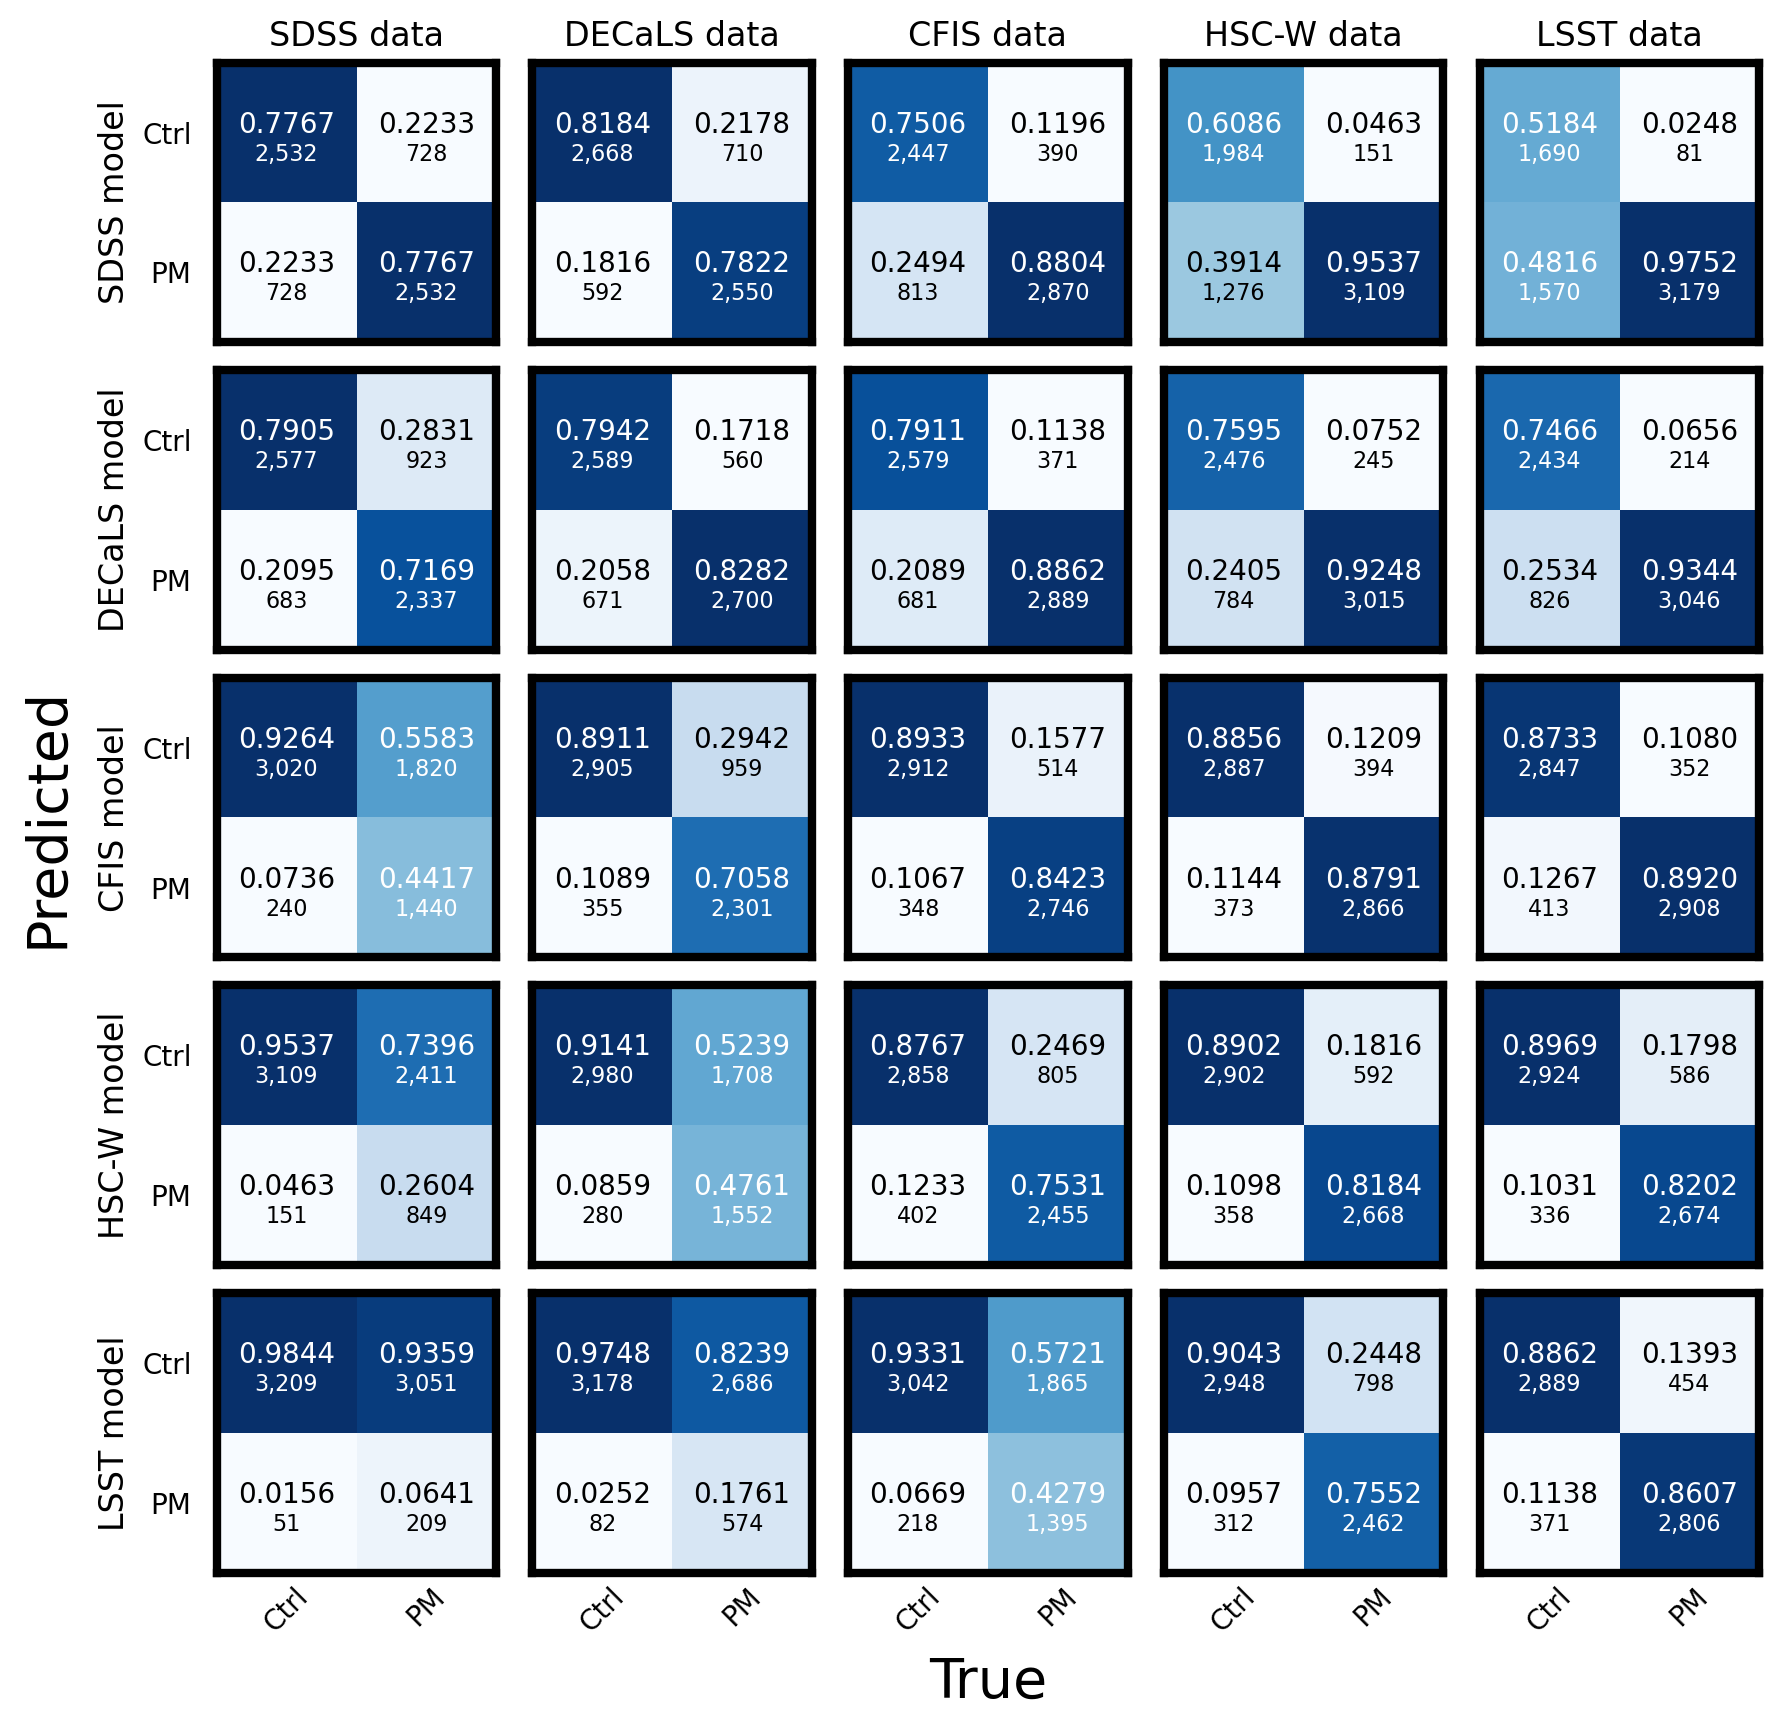

In [55]:
fig,axs = plt.subplots(5,5,figsize=[10,10],sharex=True,sharey=True,dpi=200)
for i,mname,surv in zip(range(6),['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    axs[i,0].set_ylabel('{} model'.format(surv),fontsize=12)
    for j,dname,surv2 in zip(range(6),['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
        axs[0,j].set_title('{} data'.format(surv2),fontsize=12)
        cm = confusion_matrix(y_test,np.around(pred_dict[mname+dname]))
        ax_confusion_matrix(cm,axs[i,j],['Ctrl','PM'],do_y=True,normalize=True)
        axs[i,j].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('True', labelpad=30,fontsize=20) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('Predicted', labelpad=50,fontsize=20)

plt.subplots_adjust(hspace=0.1,wspace=0.1)

plt.show()

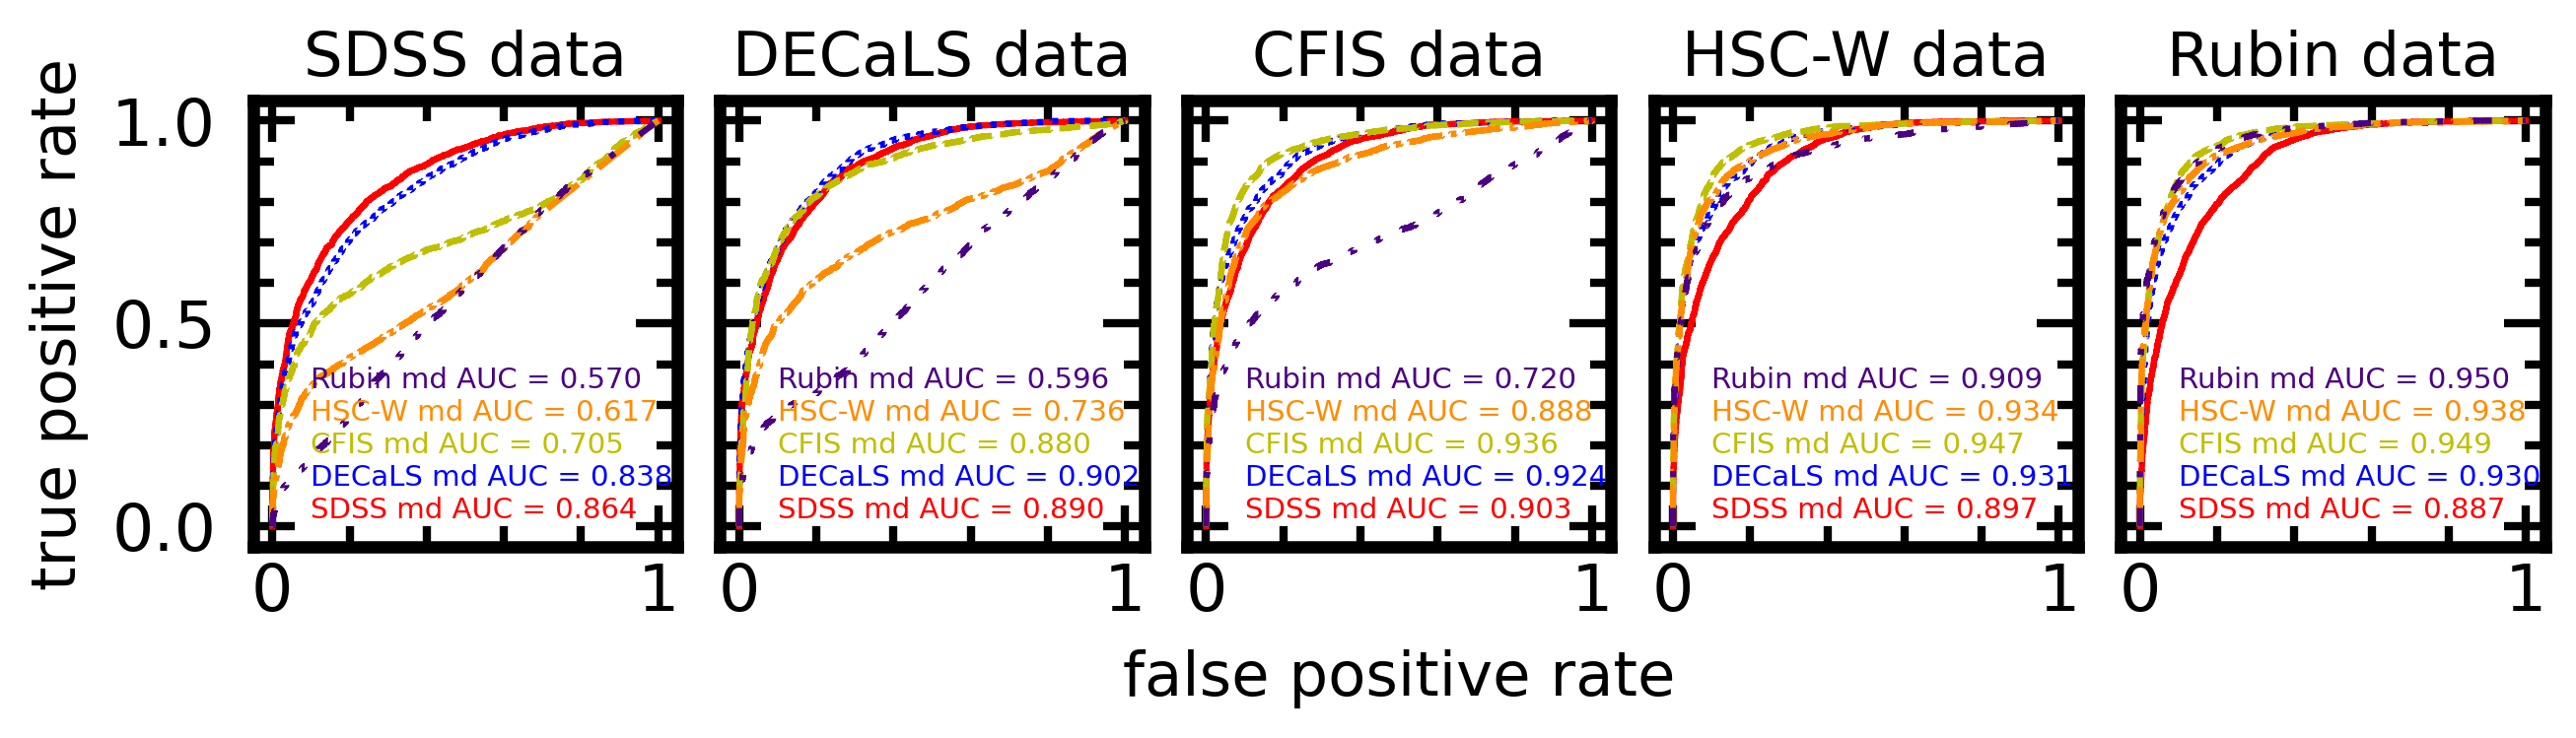

In [58]:
fig,axs = plt.subplots(1,5,figsize=[10,2],dpi=300,sharex=True,sharey=True)
for dname,survey,ax in zip(['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','Rubin'],axs.flatten()):
    ax.set_title('{} data'.format(survey),fontsize=15)
    for mname,surv2,cl,ls,xi in zip(['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','Rubin'],['r','b','y','darkorange','indigo','peru'],['solid','dotted','dashed','dashdot',(0, (3, 5, 1, 5, 1, 5)),'solid'],[0,1,2,3,4,5]):
        fpr, tpr, thresholds = roc_curve(y_test,pred_dict[mname+dname],pos_label=1)
        ax.plot(fpr,tpr,color=cl,label=surv2,linestyle=ls)
        ax.text(0.1,0.02+0.08*xi,'{} md AUC = {:0.3f}'.format(surv2,auc(fpr,tpr)),fontsize=7,color=cl)
#axs[1].legend(fontsize=8,loc='lower right')

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('false positive rate', labelpad=25,fontsize=15) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('true positive rate', labelpad=40,fontsize=15)
plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.show()

## ROC loss versus test survey
We also produce ROC curves and compute AUC scores after testing all models on all datasets. Generally, AUC scores are maximized when a given model is applied to like-generated test data. CFIS performs approximately as well on Euclid and Rubin data as it does on CFIS data according to these metrics, although it does tend to misclassify a greater number of controls as mergers when applied to imaging deeper than CFIS.

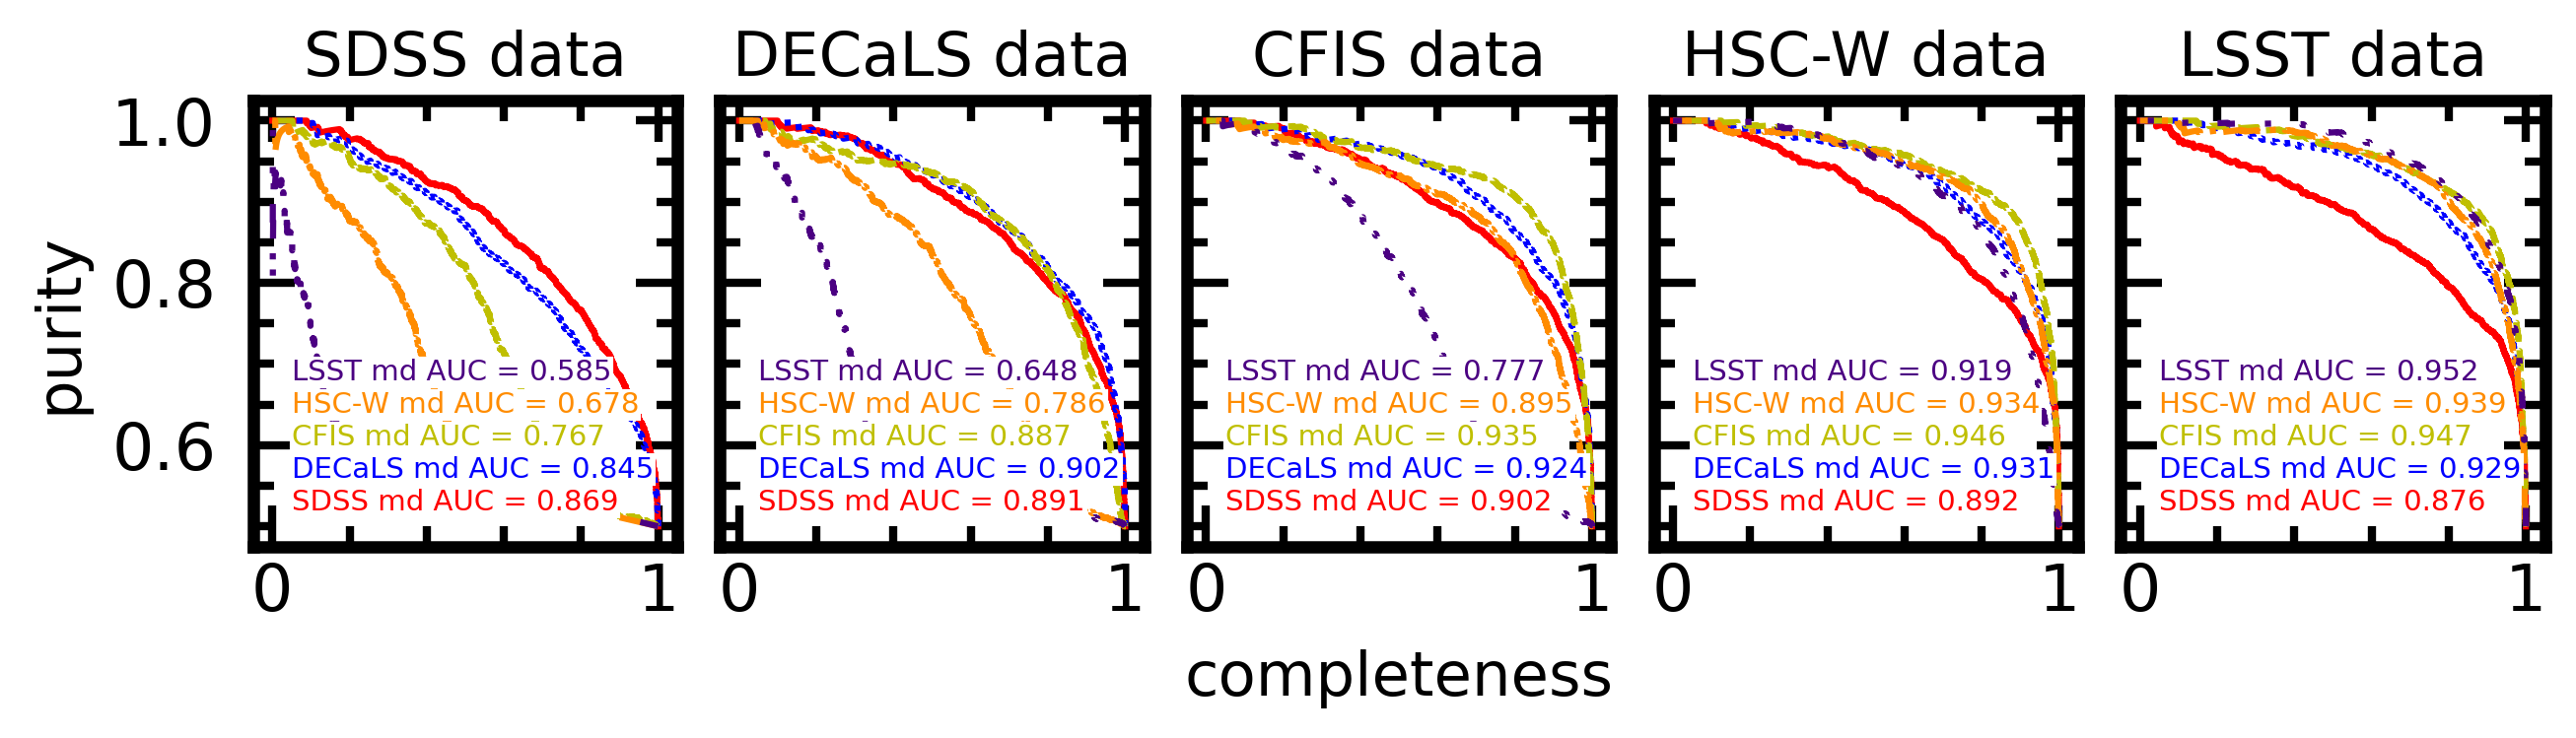

In [60]:
fig,axs = plt.subplots(1,5,figsize=[10,2],dpi=300,sharex=True,sharey=True)
axs = axs.flatten()
for dname,survey,ax in zip(['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST'],axs.flatten()):
    ax.set_title('{} data'.format(survey),fontsize=15)
    for mname,surv2,cl,ls,xi in zip(['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST'],['r','b','y','darkorange','indigo','peru'],['solid','dotted','dashed','dashdot',(0, (3, 5, 1, 5, 1, 5)),'solid'],[0,1,2,3,4,5]):
        precision, recall, thresholds = precision_recall_curve(y_test,pred_dict[mname+dname])
        ax.plot(recall,precision,color=cl,label=surv2,linestyle=ls)
        ax.text(0.05,0.52+0.04*xi,'{} md AUC = {:0.3f}'.format(surv2,auc(recall,precision)),fontsize=7,color=cl,bbox=dict(facecolor='white', edgecolor='white',pad=0.05))

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
ax.set_xlabel('completeness', labelpad=25,fontsize=15) # Use argument `labelpad` to move label downwards.
ax.set_ylabel('purity', labelpad=40,fontsize=15)
plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.show()

In [62]:
print(surveys)
surveys = ['SDSS', 'DECaLS', 'CFIS', 'HSC-W', 'LSST']
print(five_sig_psd)
print(psfs)

['SDSS', 'DECaLS', 'CFIS', 'Euclid', 'HSC-W', 'LSST']
[22.7, 23.54, 25.0, 26.5, 27.5]
[1.4, 1.18, 0.69, 0.75, 0.7]


/tmp/ipykernel_68/2785901210.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(pad=0.12)


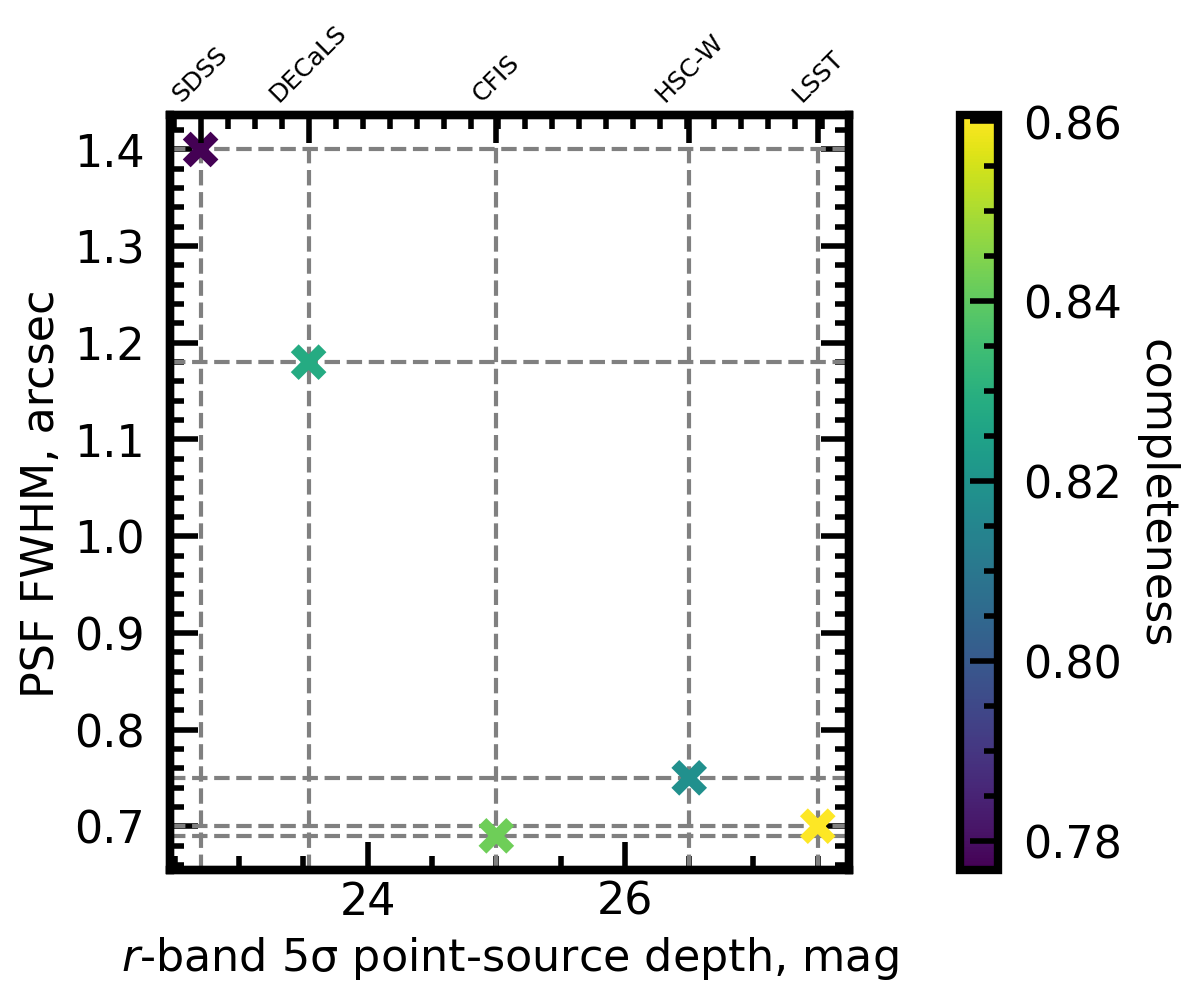

In [72]:
fig,axs = plt.subplots(1,1,figsize=[6,5],dpi=200)
depths = five_sig_psd#np.array([25.4,24,30,26.2,23])
#psfs = np.array([0.7,0.9,0.83,0.18,1.2])
merger_accs = np.array([0.7767,0.8282,0.8423,0.8184,0.8607])
ctrl_accs = np.array([0.7767,0.7942,0.8933,0.8902,0.8862])
#surveys = np.array(['CFIS','DECaLS','Rubin','Euclid','SDSS'])
total_accs = (merger_accs+ctrl_accs)/2

for i in depths:
    axs.axvline(i,color='gray',linestyle='dashed')
for i in psfs:
    axs.axhline(i,color='gray',linestyle='dashed')

plt.scatter(depths,psfs,c=merger_accs,cmap='viridis',zorder=999,marker='x',s=100,linewidth=4)
plt.xlabel('$r$-band $5\mathrm{\sigma}$ point-source depth, mag')
plt.ylabel('PSF FWHM, arcsec')

ax2 = axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(depths)
ax2.set_xticklabels(surveys,rotation=45,fontsize=9)

# ax3 = axs.twinx()
# ax3.set_ylim(axs.get_ylim())
# ax3.set_yticks(psfs)
# ax3.set_yticklabels(surveys,rotation=0,fontsize=6)

cb = plt.colorbar(pad=0.12)
cb.ax.set_ylabel('completeness',rotation=270,labelpad=20)
plt.show()

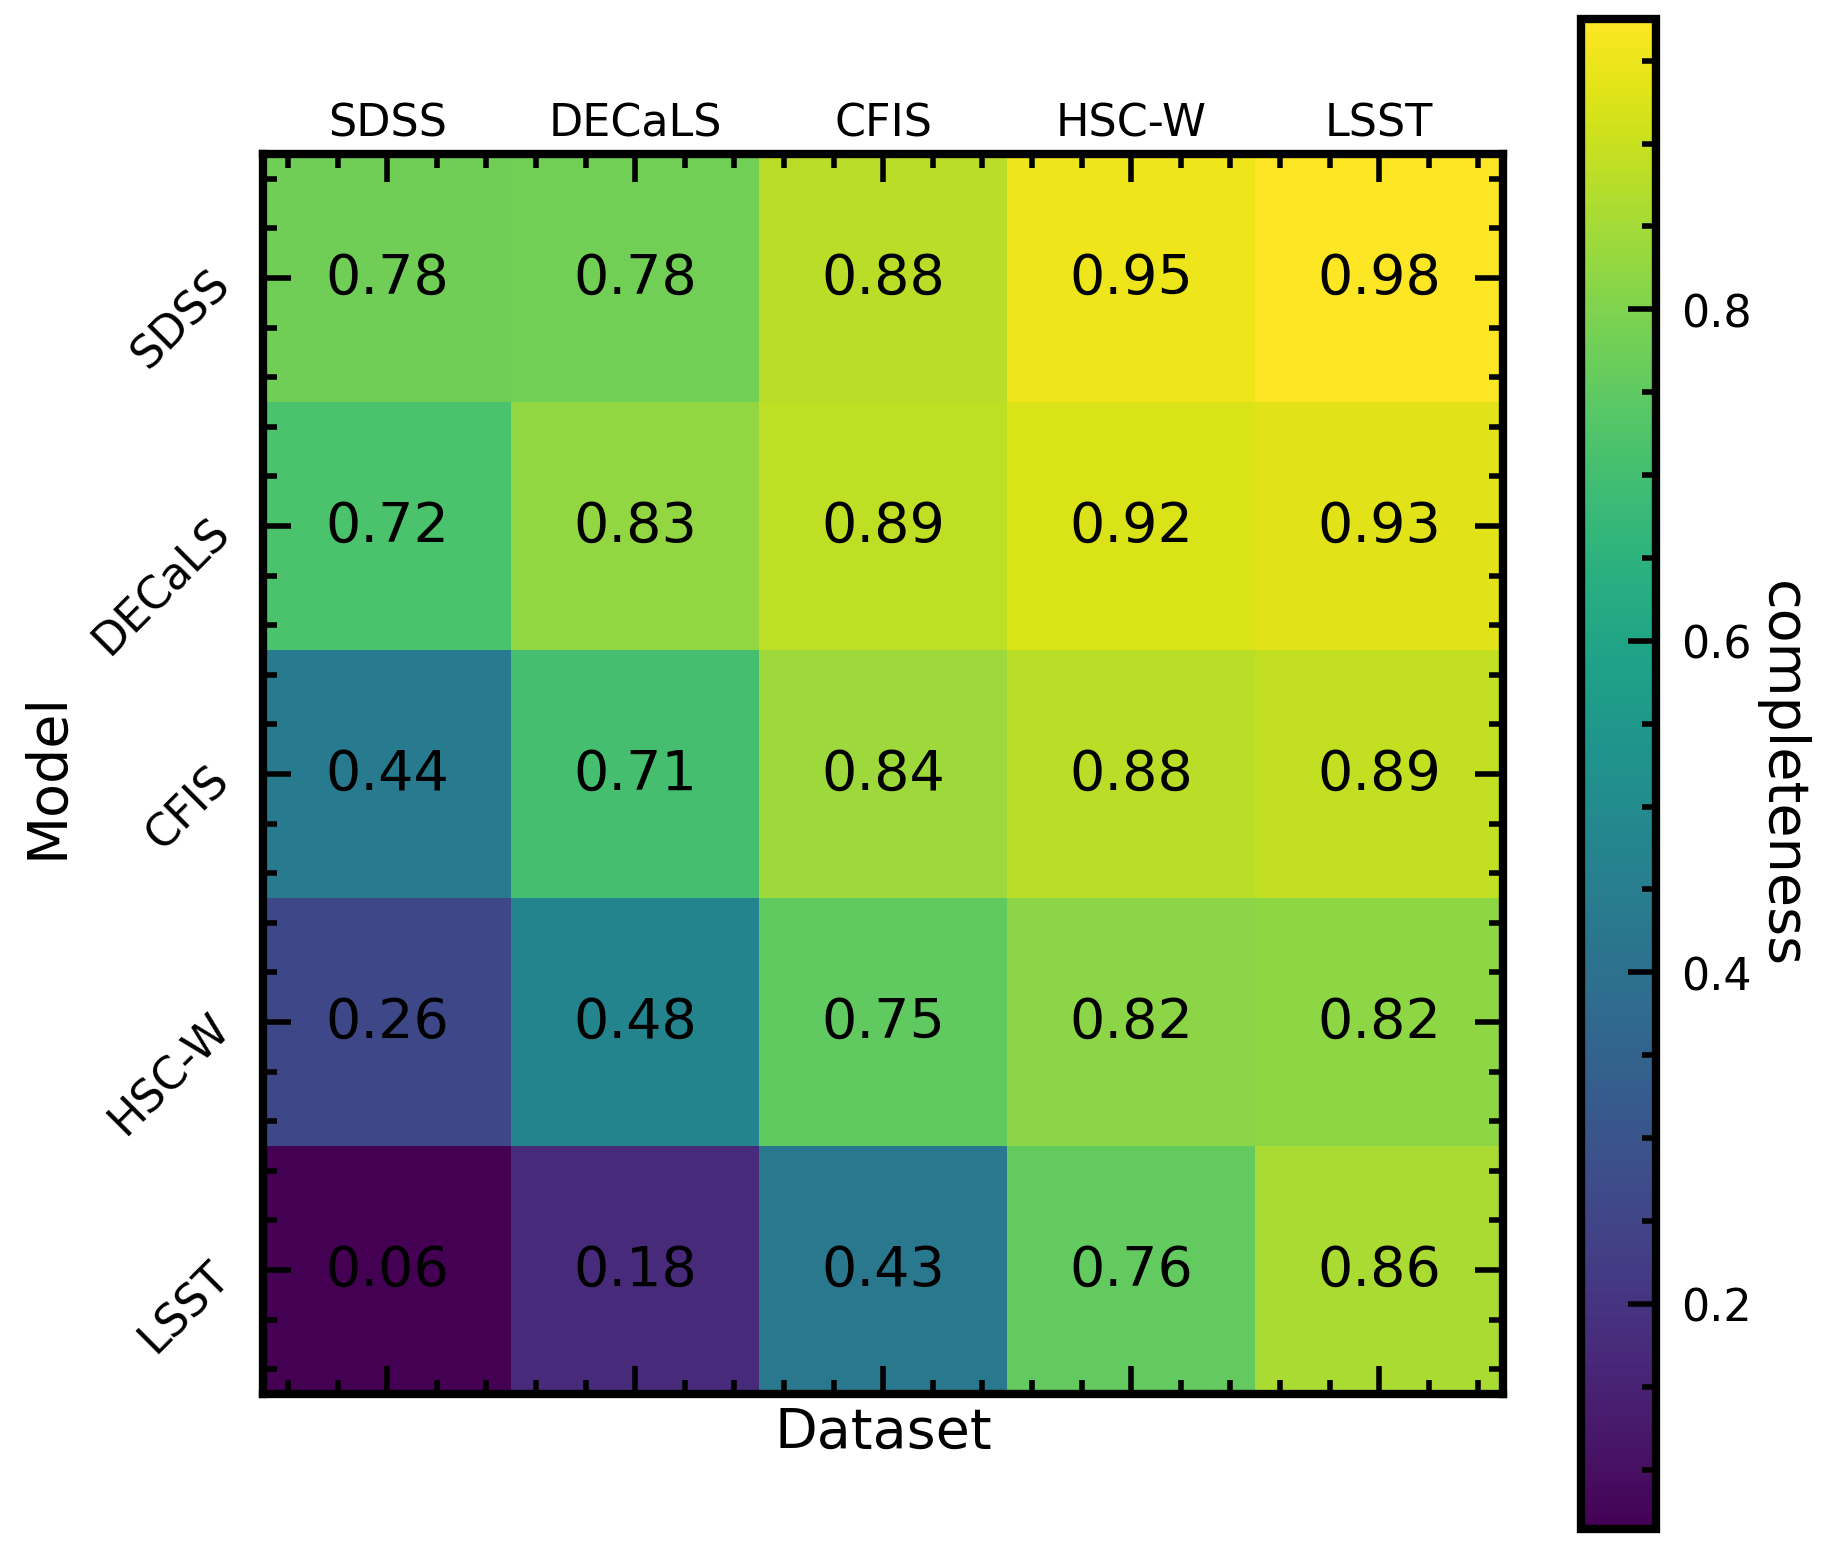

In [66]:
fig,axs = plt.subplots(1,1,figsize=[10,10],sharex=True,sharey=True,dpi=200)
mat = np.zeros([5,5])
for i,mname,surv in zip(range(6),['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    #axs[i,0].set_ylabel('{} model'.format(surv),fontsize=12)
    for j,dname,surv2 in zip(range(6),['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
        #axs[0,j].set_title('{} data'.format(surv2),fontsize=12)
        cm = confusion_matrix(y_test,np.around(pred_dict[mname+dname]),normalize='true')
        mat[i,j]=cm[1,1]

a = axs.matshow(mat,cmap='viridis')
axs.set_xlabel('Dataset',fontsize=20) # Use argument `labelpad` to move label downwards.
axs.set_ylabel('Model',fontsize=20)
for (i, j), z in np.ndenumerate(mat):
    axs.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=20)
plt.subplots_adjust(hspace=0.1,wspace=0.1)
cb = plt.colorbar(a)
cb.ax.set_ylabel('completeness',rotation=270,labelpad=20,fontsize=20)
axs.set_xticks([0,1,2,3,4])
axs.set_yticks([0,1,2,3,4])
axs.set_xticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'])
axs.set_yticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'],rotation=45)
plt.show()

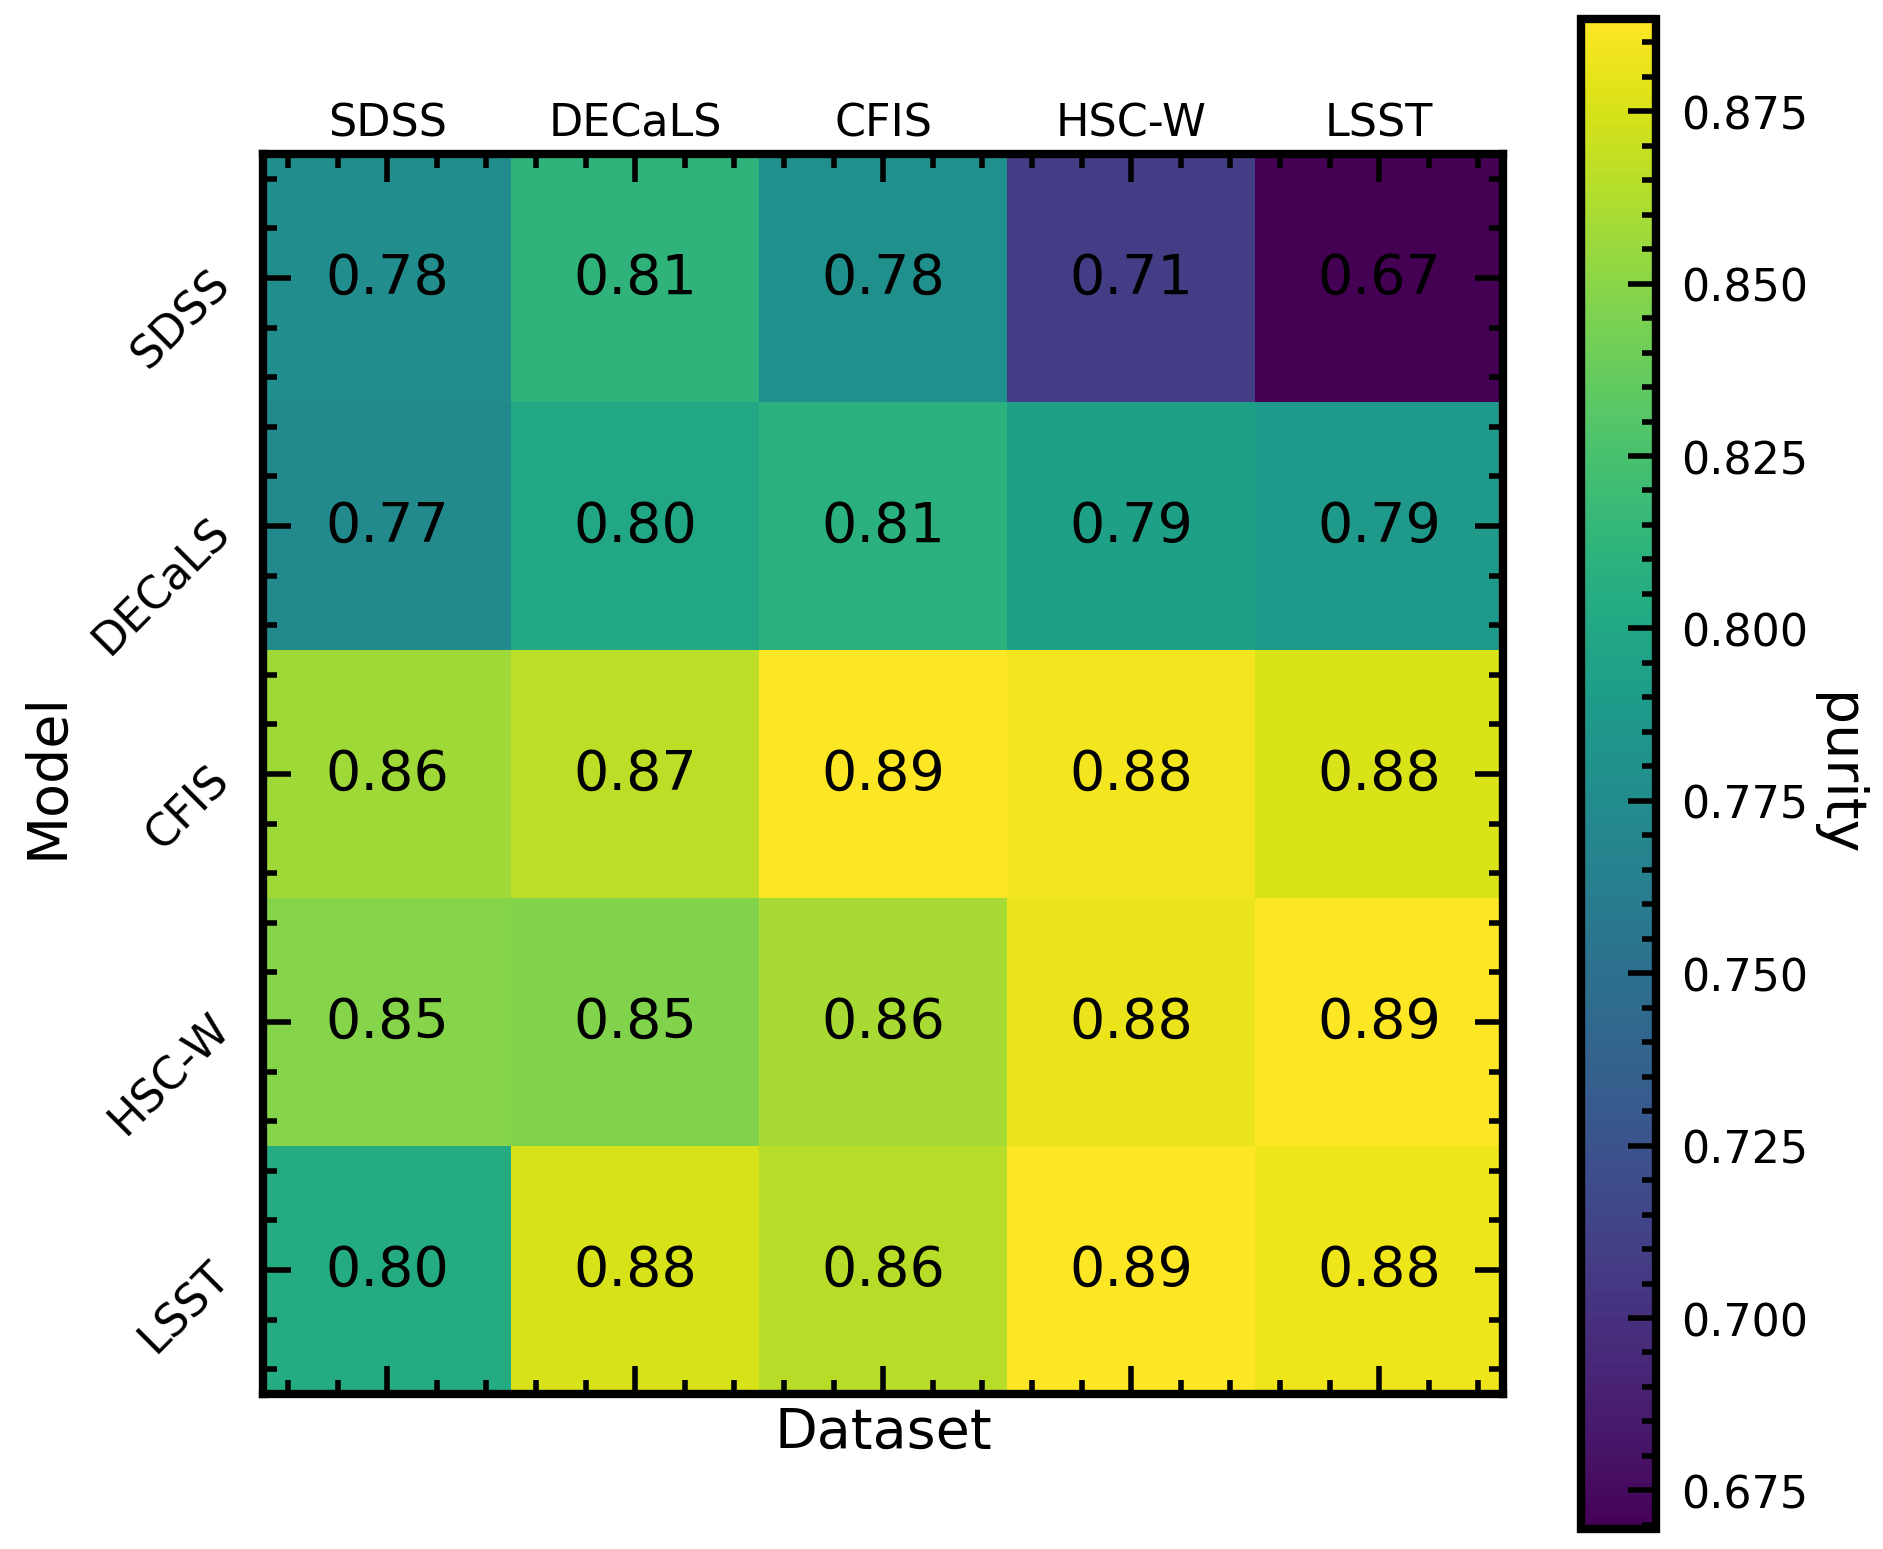

In [67]:
fig,axs = plt.subplots(1,1,figsize=[10,10],sharex=True,sharey=True,dpi=200)
mat = np.zeros([5,5])
for i,mname,surv in zip(range(6),['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    #axs[i,0].set_ylabel('{} model'.format(surv),fontsize=12)
    for j,dname,surv2 in zip(range(6),['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
        #axs[0,j].set_title('{} data'.format(surv2),fontsize=12)
        cm = confusion_matrix(y_test,np.around(pred_dict[mname+dname]),normalize='true')
        mat[i,j]=cm[1,1]/(cm[1,1]+cm[0,1])
a = axs.matshow(mat,cmap='viridis')
axs.set_xlabel('Dataset',fontsize=20) # Use argument `labelpad` to move label downwards.
axs.set_ylabel('Model',fontsize=20)
for (i, j), z in np.ndenumerate(mat):
    if np.isnan(z):
        axs.text(j, i, '', ha='center', va='center',fontsize=20)
    else:
        axs.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=20)
plt.subplots_adjust(hspace=0.1,wspace=0.1)
cb = plt.colorbar(a)
cb.ax.set_ylabel('purity',rotation=270,labelpad=20,fontsize=20)
axs.set_xticks([0,1,2,3,4])
axs.set_yticks([0,1,2,3,4])
axs.set_xticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'])
axs.set_yticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'],rotation=45)
plt.show()

Delta completeness version

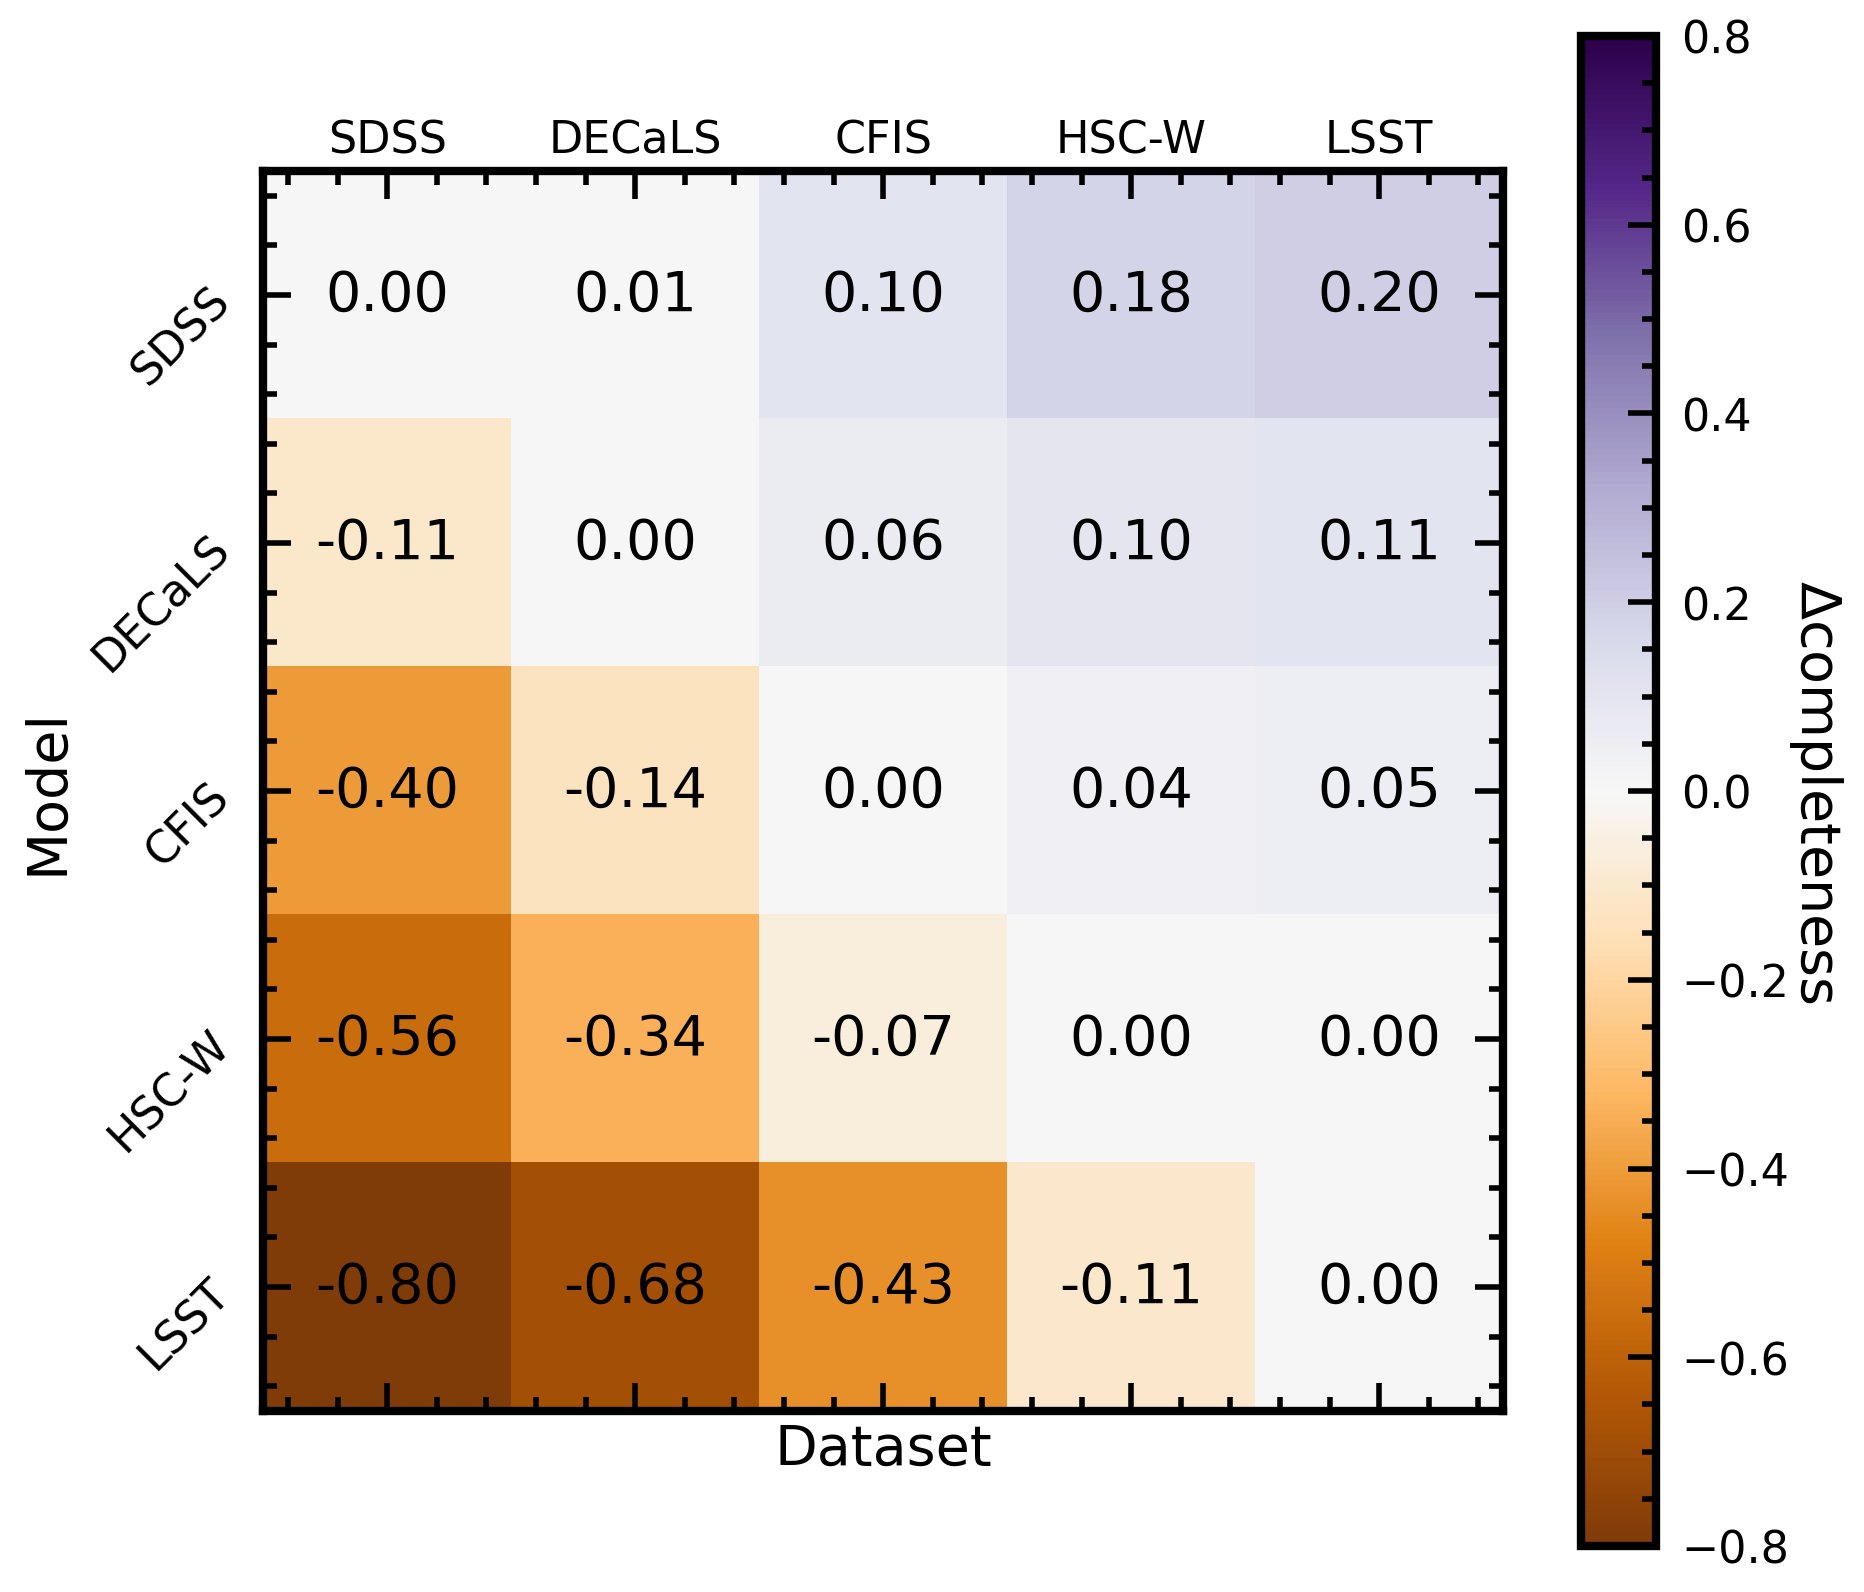

In [69]:
fig,axs = plt.subplots(1,1,figsize=[10,10],sharex=True,sharey=True,dpi=200)
mat = np.zeros([5,5])
for i,mname,surv in zip(range(6),['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    #axs[i,0].set_ylabel('{} model'.format(surv),fontsize=12)
    for j,dname,surv2 in zip(range(6),['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
        #axs[0,j].set_title('{} data'.format(surv2),fontsize=12)
        cm = confusion_matrix(y_test,np.around(pred_dict[mname+dname]),normalize='true')
        mat[i,j]=cm[1,1]

mat2 = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        mat2[i,j] = mat[i,j]-mat[i,i]

a = axs.matshow(mat2,cmap='PuOr',vmin=-0.8, vmax=0.8)
axs.set_xlabel('Dataset',fontsize=20) # Use argument `labelpad` to move label downwards.
axs.set_ylabel('Model',fontsize=20)
for (i, j), z in np.ndenumerate(mat2):
    axs.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=20)
plt.subplots_adjust(hspace=0.1,wspace=0.1)
cb = plt.colorbar(a)
cb.ax.set_ylabel('$\Delta$completeness',rotation=270,labelpad=20,fontsize=20)
axs.set_xticks([0,1,2,3,4])
axs.set_yticks([0,1,2,3,4])
axs.set_xticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'])
axs.set_yticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'],rotation=45)
plt.show()

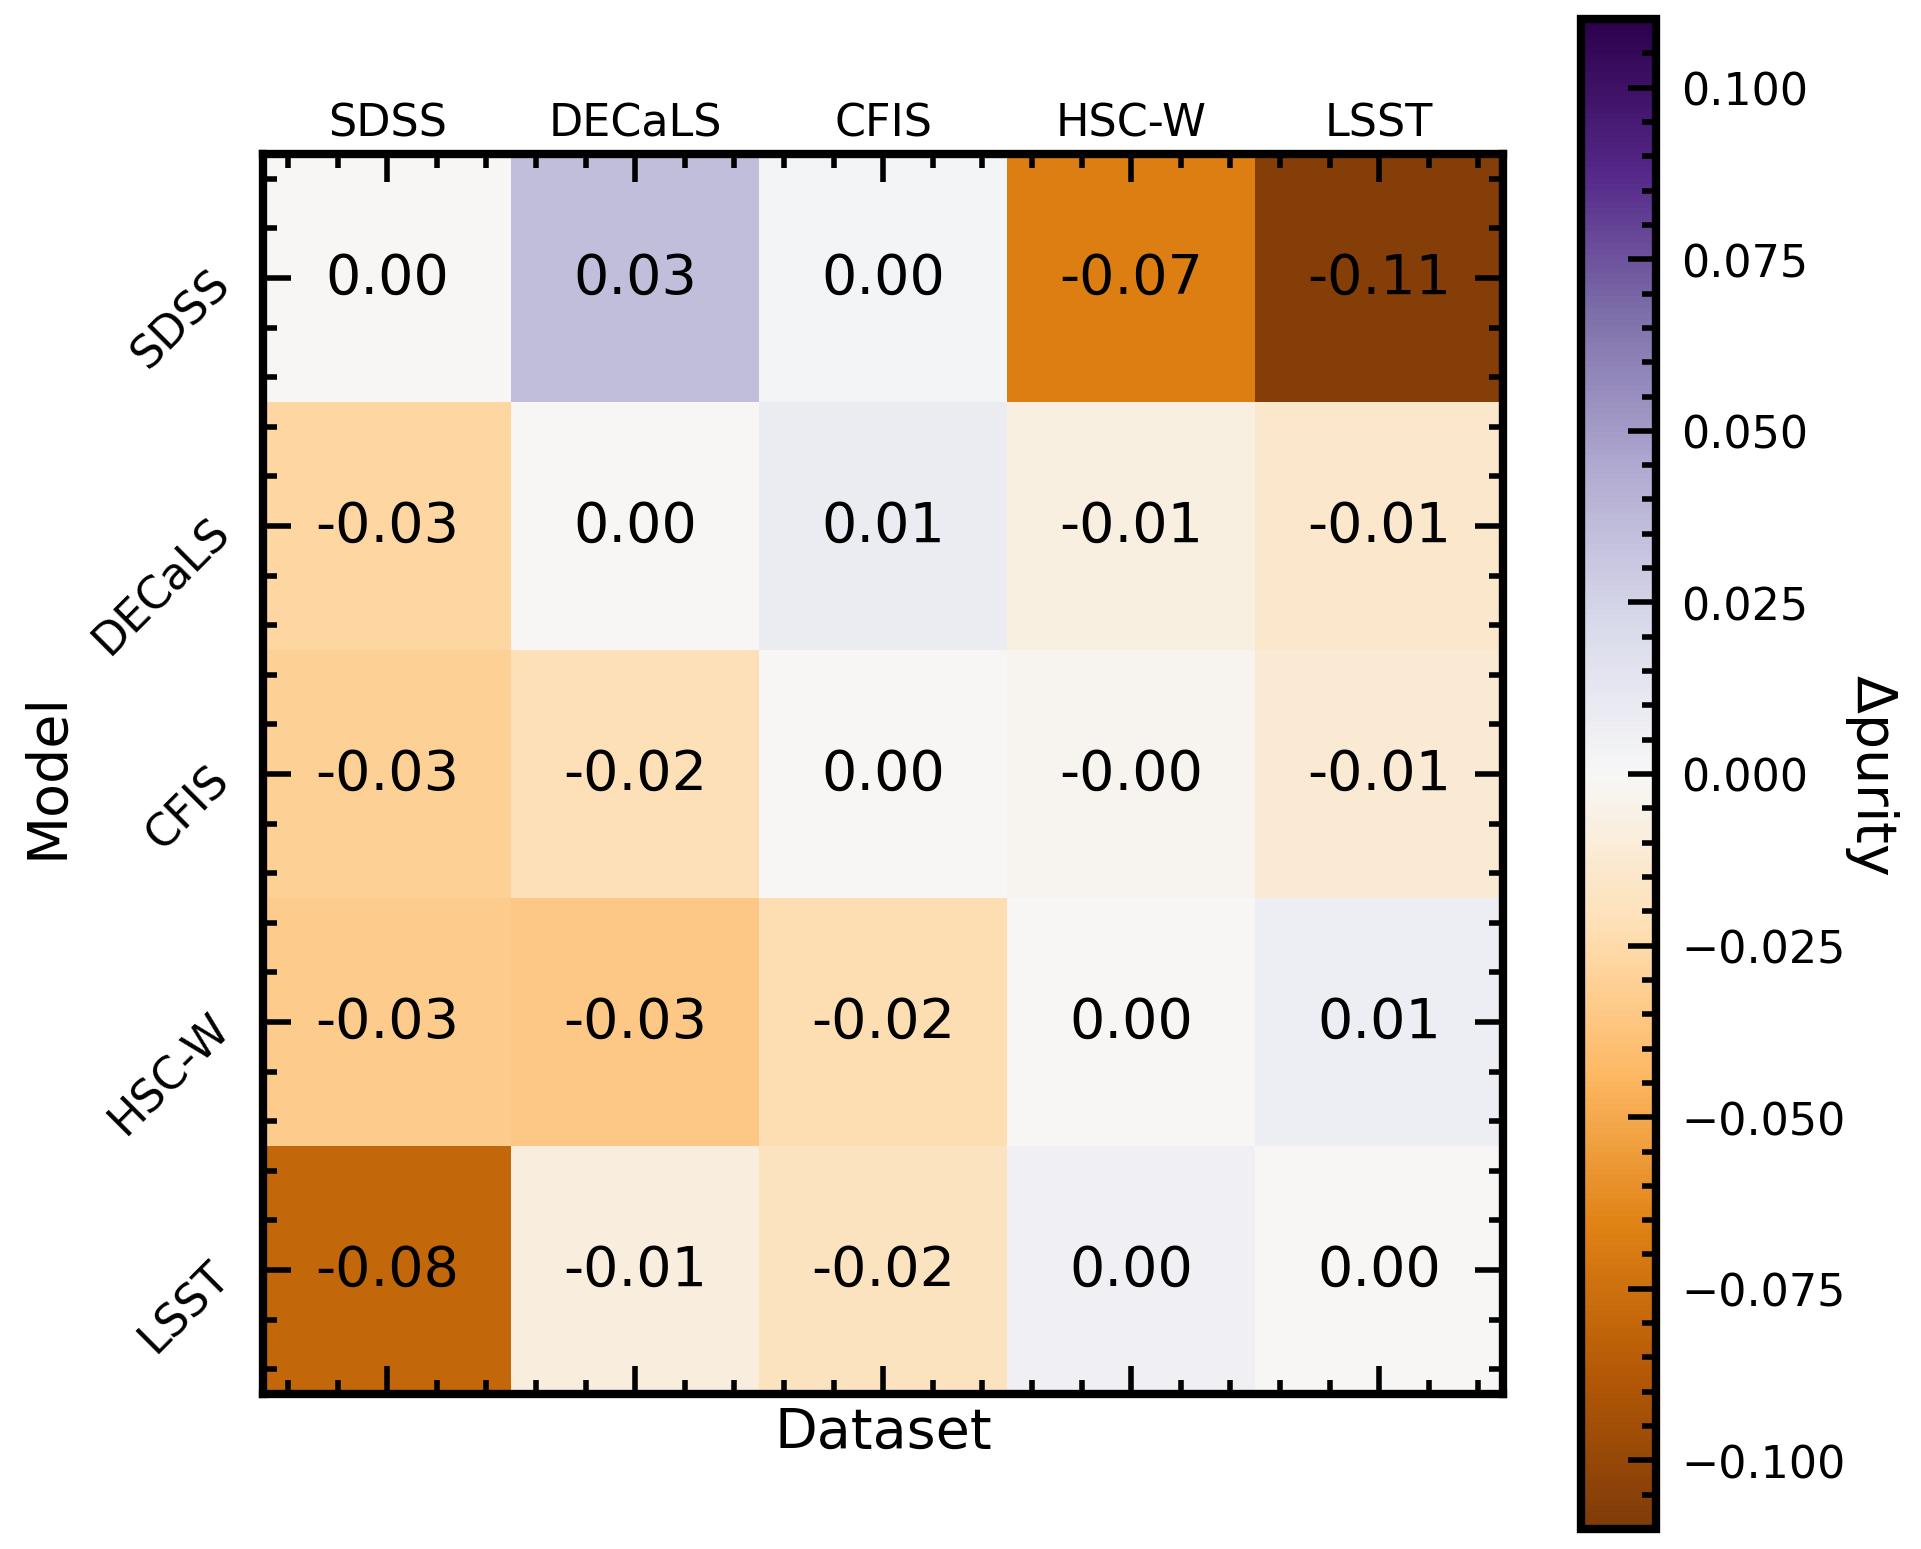

In [71]:
fig,axs = plt.subplots(1,1,figsize=[10,10],sharex=True,sharey=True,dpi=200)
mat = np.zeros([5,5])
for i,mname,surv in zip(range(6),['mS','mD','mC','mH','mL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    #axs[i,0].set_ylabel('{} model'.format(surv),fontsize=12)
    for j,dname,surv2 in zip(range(6),['iS','iD','iC','iH','iL'],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
        #axs[0,j].set_title('{} data'.format(surv2),fontsize=12)
        cm = confusion_matrix(y_test,np.around(pred_dict[mname+dname]),normalize='true')
        mat[i,j]=cm[1,1]/(cm[1,1]+cm[0,1])
    
mat2 = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        mat2[i,j] = mat[i,j]-mat[i,i]
        

a = axs.matshow(mat2,cmap='PuOr',vmin=-0.11,vmax=0.11)
axs.set_xlabel('Dataset',fontsize=20) # Use argument `labelpad` to move label downwards.
axs.set_ylabel('Model',fontsize=20)
for (i, j), z in np.ndenumerate(mat2):
    if np.isnan(z):
        axs.text(j, i, '', ha='center', va='center',fontsize=20)
    else:
        axs.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=20)
plt.subplots_adjust(hspace=0.1,wspace=0.1)
cb = plt.colorbar(a)
cb.ax.set_ylabel('$\Delta$purity',rotation=270,labelpad=20,fontsize=20)
axs.set_xticks([0,1,2,3,4])
axs.set_yticks([0,1,2,3,4])
axs.set_xticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'])
axs.set_yticklabels(['SDSS','DECaLS','CFIS','HSC-W','LSST'],rotation=45)
plt.show()

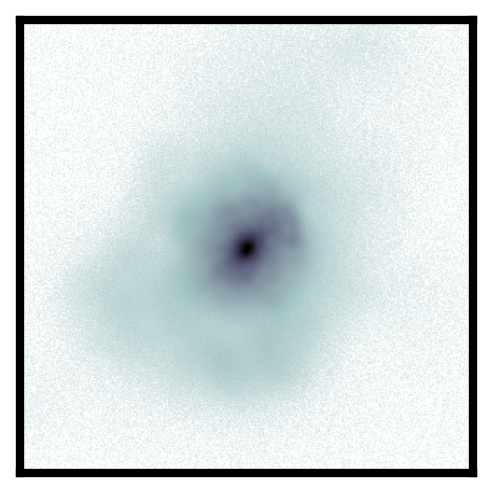

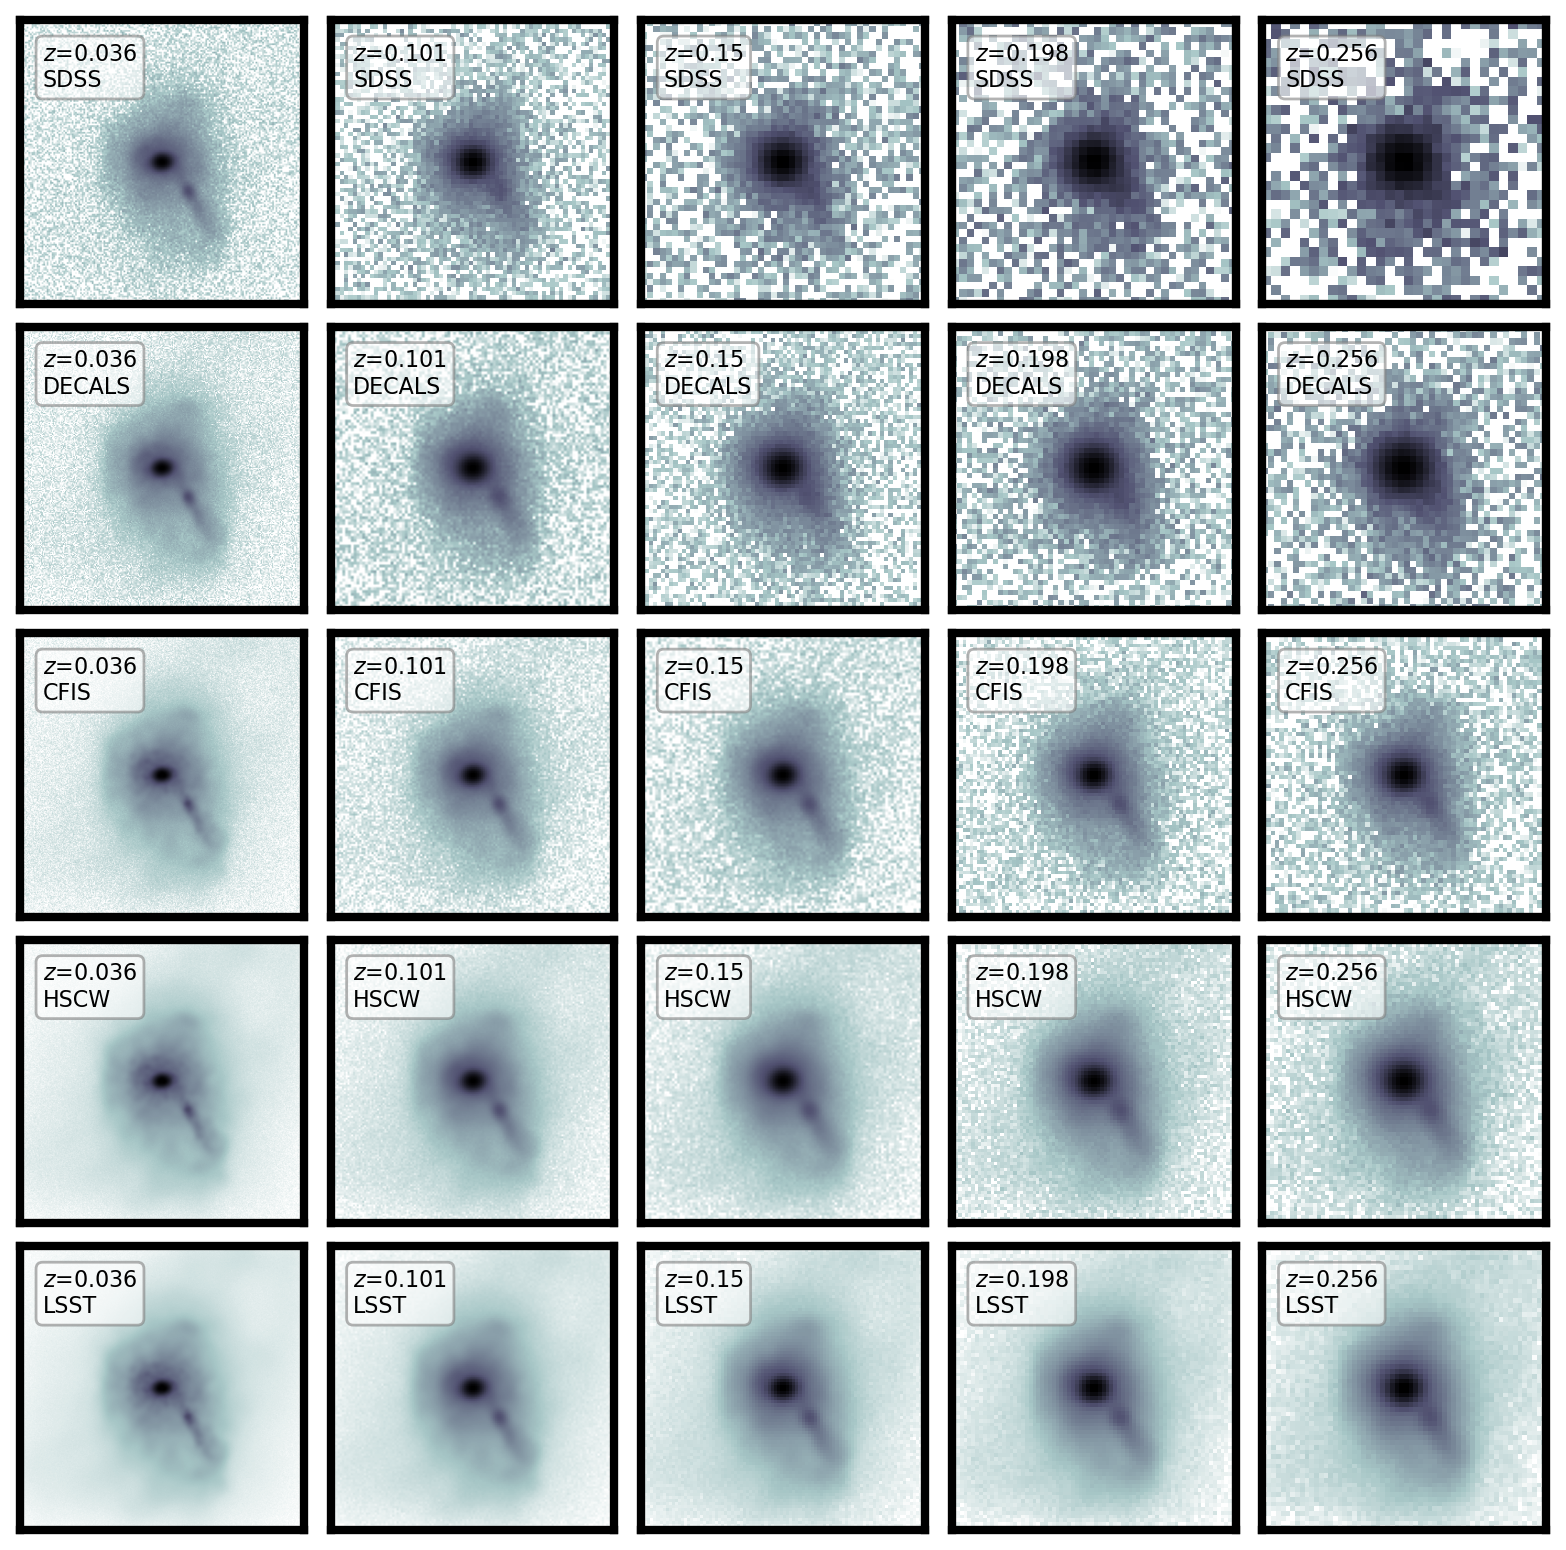

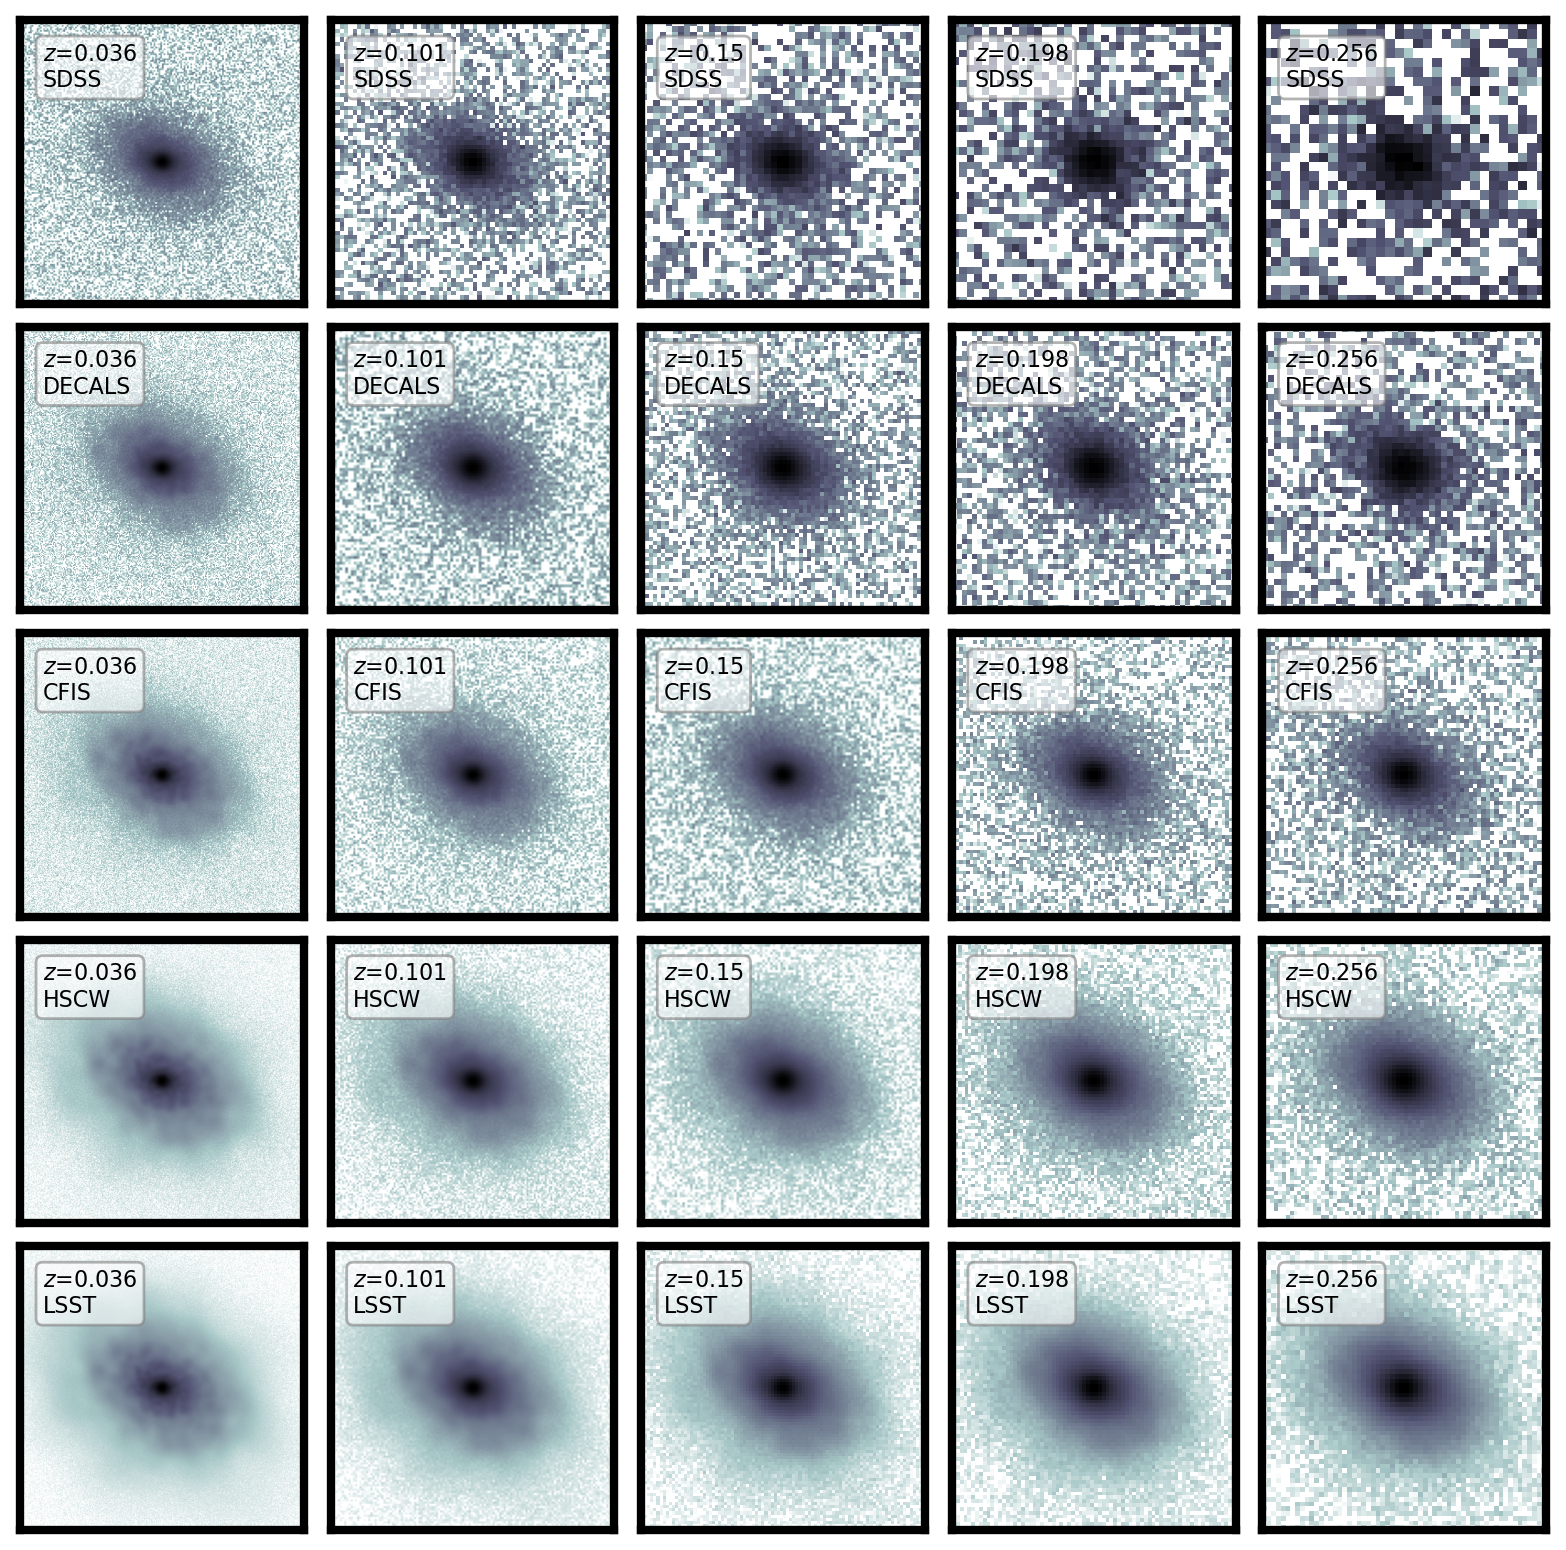

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm.notebook import tqdm
import random
data_dir = '/arc/projects/MachineLearning/Bobby/obs_proj_dat/'
df = pd.read_pickle(data_dir+'sample_catalog_pandas.pk')
df
#make a function to do make nice visualizations of the data
def prepare_im(i):
    im = np.array(i).clip(min=0)
    mean = np.mean(im.flatten())
    std = np.std(im.flatten())
    im = (im-mean)/std
    im = im - np.amin(im)+0.01
    im = np.log10(im)
    return im
#testing cell
snapnum = 50
filename = data_dir+'MULTISURVEY_BOBBY_{}.h5'.format(snapnum)
with h5py.File(filename, 'r') as f:
    data = f['50_104756']['CFIS']['cam0']['z0'][()]
fig,axs = plt.subplots(figsize=[3,3],dpi=200)
plt.imshow(prepare_im(data),cmap='bone_r')
axs.tick_params(axis='both', which='both', length=0)
axs.set_xticklabels('')
axs.set_yticklabels('')
plt.show()
#Function that gets the image for a given galaxy from the h5 list
#structured as snapshot_file/DB_ID/survey/camera/redshift

def get_im(DB_ID,survey,cam,z): #nice version for viewing the images at their generated resolution
    snapnum = DB_ID[:2]
    filename = data_dir+'MULTISURVEY_BOBBY_{}.h5'.format(snapnum)
    with h5py.File(filename, 'r') as f:
        data = f[DB_ID][survey][cam][z][()]
    return data

#choose a size for the science images now
all_size=128

def get_gal_ims_sci(DB_ID,survey): #science version which rescales and normalizes all images corresponding to one galaxy
    snapnum = DB_ID[:2]
    filename = data_dir+'MULTISURVEY_BOBBY_{}.h5'.format(snapnum)
    imlist = []
    with h5py.File(filename, 'r') as f:
        for z in ['z0','z1','z2','z3','z4']:
            for cam in ['cam0','cam1','cam2','cam3']:
                data = f[DB_ID][survey][cam][z][()]
                data = resize(data,(all_size,all_size),anti_aliasing=True)
                data = data-np.amin(data)
                data = data/np.amax(data)+0.01 #adding 1% to avoid the zero flux pixel that results from this.
                imlist.append(data)
    return imlist
#post-merger at five diff image qualities at all redshifts
fig,axs = plt.subplots(5,5,figsize=[10,10],dpi=200)
DB_ID = df[df['label']=='merger']['DB_ID'].iloc[0]
bbox_props = dict(boxstyle='round', fc='w', ec='0.5', alpha=0.6)
for survey,i in zip(['SDSS','DECALS','CFIS','HSCW','LSST'],range(5)):
    for z,fz,j in zip(['z0','z1','z2','z3','z4'],['$z$=0.036', '$z$=0.101', '$z$=0.15', '$z$=0.198','$z$=0.256'],range(5)):
        axs[i,j].imshow(prepare_im(get_im(DB_ID,survey,'cam0',z)),cmap='bone_r')
        axs[i,j].tick_params(axis='both', which='both', length=0)
        axs[i,j].set_xticklabels('')
        axs[i,j].set_yticklabels('')
        axs[i,j].text(.08, .92, '{}\n{}'.format(fz,survey), transform=axs[i,j].transAxes, ha='left', va='top',fontsize=8,bbox=bbox_props)
plt.subplots_adjust(hspace=0.08,wspace=0.01)
plt.show()

#control at five diff image qualities at all redshifts
fig,axs = plt.subplots(5,5,figsize=[10,10],dpi=200)
DB_ID = df[df['label']=='control']['DB_ID'].iloc[0]
bbox_props = dict(boxstyle='round', fc='w', ec='0.5', alpha=0.6)
for survey,i in zip(['SDSS','DECALS','CFIS','HSCW','LSST'],range(5)):
    for z,fz,j in zip(['z0','z1','z2','z3','z4'],['$z$=0.036', '$z$=0.101', '$z$=0.15', '$z$=0.198', '$z$=0.256'],range(5)):
        axs[i,j].imshow(prepare_im(get_im(DB_ID,survey,'cam0',z)),cmap='bone_r')
        axs[i,j].tick_params(axis='both', which='both', length=0)
        axs[i,j].set_xticklabels('')
        axs[i,j].set_yticklabels('')
        axs[i,j].text(.08, .92, '{}\n{}'.format(fz,survey), transform=axs[i,j].transAxes, ha='left', va='top',fontsize=8,bbox=bbox_props)
plt.subplots_adjust(hspace=0.08,wspace=0.01)
plt.show()

In [58]:
mu_space = np.linspace(0.1,1,10)
DB_IDs = [df[(df['label']=='merger')&(df.MassRatio>mu_space[i])&(df.MassRatio<mu_space[i+1])&(df.SubhaloMassInRadType_stars>10.4)&(df.SubhaloMassInRadType_stars<10.6)]['DB_ID'].iloc[0] for i in range(len(mu_space)-1)]
mus = [df[(df['label']=='merger')&(df.MassRatio>mu_space[i])&(df.MassRatio<mu_space[i+1])&(df.SubhaloMassInRadType_stars>10.4)&(df.SubhaloMassInRadType_stars<10.6)]['MassRatio'].iloc[0] for i in range(len(mu_space)-1)]

print(DB_IDs)
print(mus)

['52_268551', '96_481818', '52_291357', '50_274959', '57_326645', '95_475645', '78_407477', '72_327294', '53_266608']
[0.192085, 0.27859, 0.393792, 0.477932, 0.59285, 0.648121, 0.771236, 0.836855, 0.981408]


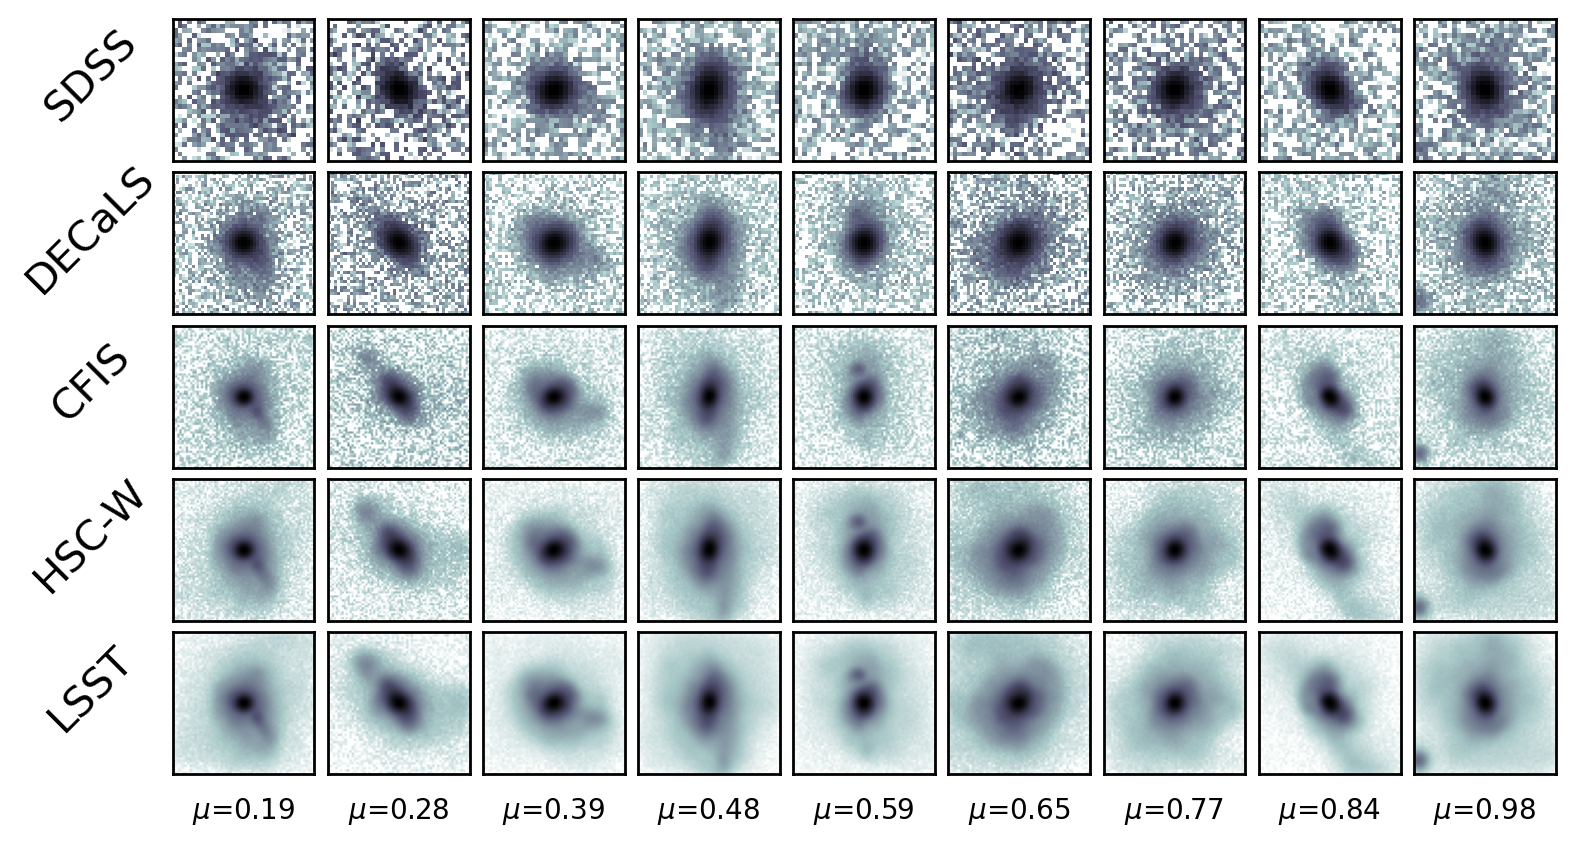

In [59]:
#post-merger at five diff image qualities at high redshift
mpl.rcParams['axes.linewidth'] = 1
fig,axs = plt.subplots(5,9,figsize=[9,5],dpi=200)
bbox_props = dict(boxstyle='round', fc='w', ec='0.5', alpha=0.6)
for survey,i in zip(['SDSS','DECALS','CFIS','HSCW','LSST'],range(5)):
    for DB_ID,mu,j in zip(DB_IDs,mus,range(9)):
        axs[i,j].imshow(prepare_im(get_im(DB_ID,survey,'cam0','z4')),cmap='bone_r')
        axs[i,j].tick_params(axis='both', which='both', length=0)
        axs[i,j].set_xticklabels('')
        axs[i,j].set_yticklabels('')
        #axs[i,j].text(.08, .92, '$\mu$={}\n{}\n$z$=0.256'.format(mu,survey), transform=axs[i,j].transAxes, ha='left', va='top',fontsize=8,bbox=bbox_props)
plt.subplots_adjust(hspace=0.08,wspace=0.01)
for ax,survey in zip(axs[:,0],['SDSS','DECaLS','CFIS','HSC-W','LSST']):
    ax.set_ylabel(survey,rotation=45,fontsize=15,labelpad=15)
for ax,mu in zip(axs[-1,:],mus):
    ax.set_xlabel('$\mu$={}'.format(round(mu,2)),fontsize=10)
plt.show()

Text(0, 0.5, 'Post-merger posterior, Pr($A|B$)')

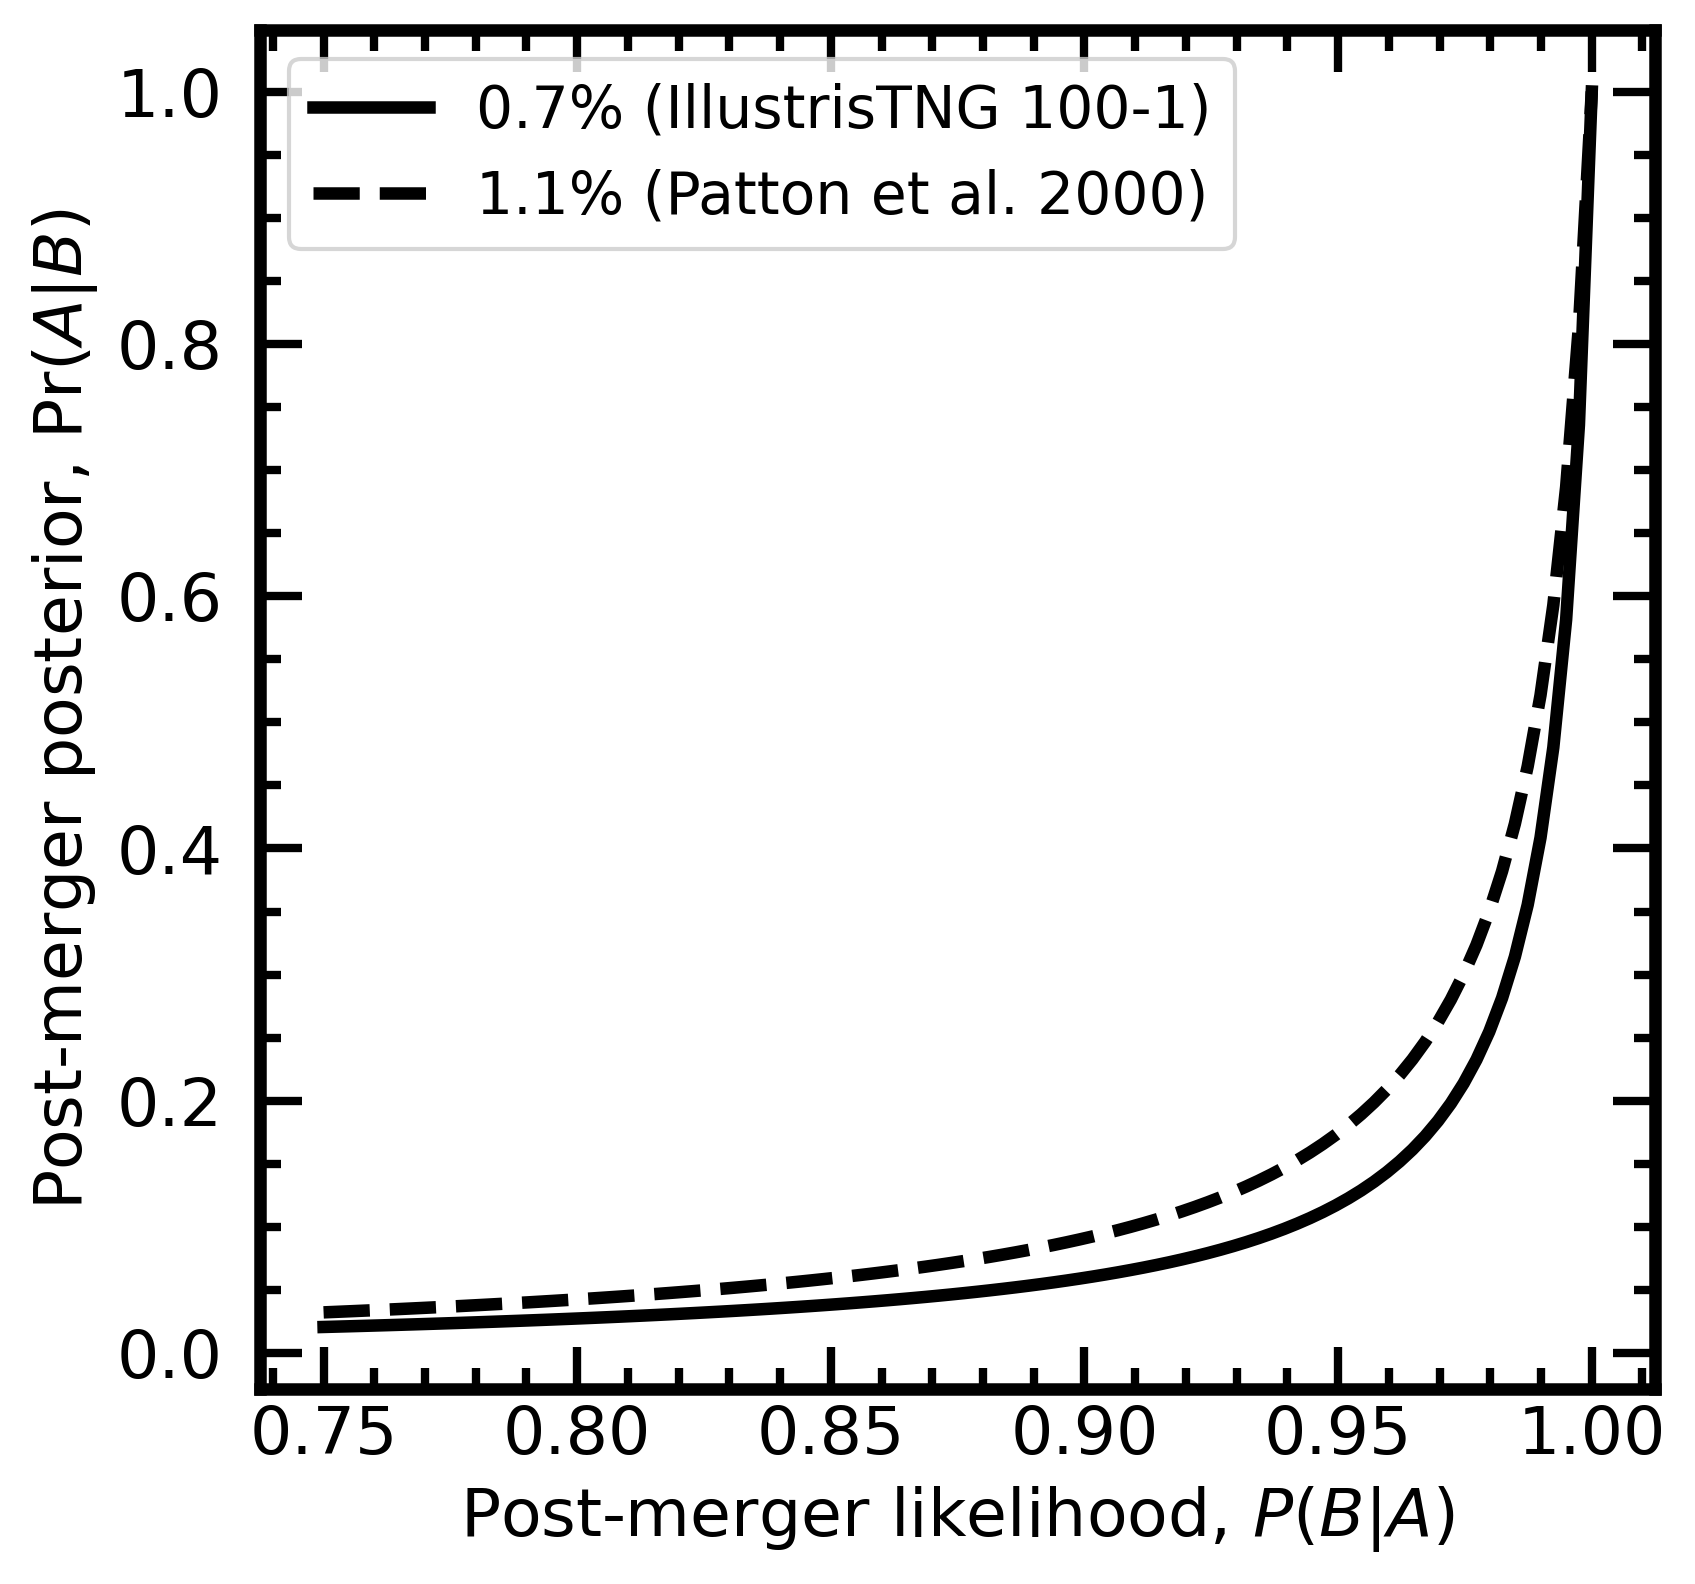

In [13]:
fig,axs = plt.subplots(figsize=[6,6],dpi=300)
xdat = np.linspace(0.75,1,100)
ydat = [(x*0.007)/(x*0.007+(1-x)*(1-0.007)) for x in xdat]
plt.plot(xdat,ydat,c='black',label='0.7% (IllustrisTNG 100-1)',linewidth=3)
ydat = [(x*0.011)/(x*0.011+(1-x)*(1-0.011)) for x in xdat]
plt.plot(xdat,ydat,c='black',linestyle='dashed',label='1.1% (Patton et al. 2000)',linewidth=3)
plt.legend()
plt.xlabel('Post-merger likelihood, $P(B|A)$')
plt.ylabel('Post-merger posterior, Pr($A|B$)')